# Check Bounding Boxex NIH

In [41]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
from os import listdir
from os.path import isfile, join
import sys
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from matplotlib import patches
from matplotlib.collections import PatchCollection
#import matplotlib
from PIL import Image, ImageDraw
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib import pyplot
from skimage.color import rgb2gray, gray2rgb
from skimage.filters import threshold_otsu
from shapely.geometry.polygon import Polygon as Polygon_shapley
# from multiprocessing import Pool
import multiprocessing
import time
import random
import pickle
import png
from scipy.spatial import ConvexHull
import bbox_visualizer as bbv
sys.path.insert(0, os.path.dirname(os.path.abspath('.'))) # to make imports relative to project root work

First download files from ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/NIH-NLM-ThinBloodSmearsPf/ to folder (see the terminal comand below) e.g.

NIH_NLM_ThinBloodSmears <br>
└-Point Set <br>
└-Polygon Set <br>
Notebooks <br>
└-IH_bounding_boxes.ipynb <br>

In the Terminal navigate to the folder you want your data in (**cd** then drag and drop the folder) then enter following:

wget -r -np ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/NIH-NLM-ThinBloodSmearsPf/

(you might need to install wget with **brew install wget** and if you do not have brew then install homebrew https://brew.sh/)


In [42]:
def get_txt(path):
    list_txt = []
    # Delimiter
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".txt"):
                txt_path = os.path.join(root, file)
                list_txt.append(txt_path)
    return list_txt


def txt_to_df(path):
    data_file_delimiter = ','
    df = pd.DataFrame(columns = [ 'Patient no - Cell no','cell', 'comment', 'annotation_type','Number of points', 'position', 'filename', 'txt_path', 'img_path'])
    root, file = os.path.split(path)
    filename, file_extension = os.path.splitext(file)
    txt_path = os.path.join(root, file)
    img_path = os.path.join(root.replace("GT", "Img"), filename +'.jpg')
    # Loop the data lines
    with open(txt_path, 'r') as temp_f:
        # Read the lines
        lines = temp_f.readlines()
        lines.pop(0)
        for l in lines:
            # Count the column count for the current line
            columns = l.split(data_file_delimiter)
            list_locations = [int(float(location)) for location in columns[5:]]
            zip_locations = list(zip(list_locations[::2], list_locations[1::2]))
            df = df.append( {'Patient no - Cell no': columns[0], 'cell': columns[1], 'comment': columns[2], 'annotation_type': columns[3], \
                'Number of points': columns[4], 'position': zip_locations, 'filename': filename, 'txt_path': txt_path, 'img_path': img_path}, ignore_index = True)
    return df

def collect_results(df_collected):
    """Uses apply_async's callback to setup up a separate Queue for each process"""
    global df
    df = df.append(df_collected)


In [43]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def draw_points(img, cell, annotation, position, row, rows = 1, columns = 1, i = 1, point_size = 15):
    colour = (0,255,0) if cell == 'Uninfected' \
        else (255,0, 0) if cell == 'Parasitized' \
            else (128,0, 128) if cell == 'Platelet' \
                else (0, 0, 255) if cell == 'White_Blood_Cell' \
                    else (255,215,0)

    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(row['filename'])

    if annotation == 'Point':
        x = position[0][0] 
        y = position[0][1] 
        cv2.circle(img, position[0], 1, colour, point_size)
    
    elif annotation == 'Polygon':
        if len(position) < 3:
            print('row: ', row)
        if not len(position) < 3:
            poly = Polygon_shapley(position)
            x,y = poly.exterior.xy
            ax.plot(x, y, color=rgb_to_hex(colour), alpha=0.7,
                linewidth=3, solid_capstyle='round', zorder=2)


In [44]:
txt_list = get_txt('../NIH-NLM-ThinBloodSmearsPf')
print(len(txt_list))

965


**The following operation takes a while lean back and get a coffee**

In [45]:
# df = pd.DataFrame(columns = [ 'Patient no - Cell no','cell', 'comment', 'annotation_type','Number of points', 'position', 'filename', 'txt_path', 'img_path'])
# start_time = time.time()  

# # Repeats the compute intensive operation on all available cores
# pool = multiprocessing.Pool(processes = multiprocessing.cpu_count())
# pool.map_async(txt_to_df, txt_list, callback = collect_results)
# pool.close()
# pool.join()

# # Converts list of lists to a data frame
# print(df.shape)
# print("--- %s seconds ---" % (time.time() - start_time))

In [46]:
# df.reset_index(drop=True, inplace = True)
# pickle_labels = open('labels.pkl', 'wb') 
# pickle.dump(df, pickle_labels)

In [47]:
df = pd.read_pickle('labels.pkl')

In [48]:
df

Patient no - Cell no         cell     comment annotation_type  \
0                       1-1  Parasitized  No_Comment           Point   
1                       1-2   Uninfected  No_Comment           Point   
2                       1-3   Uninfected  No_Comment           Point   
3                       1-4   Uninfected  No_Comment           Point   
4                       1-5   Uninfected  No_Comment           Point   
...                     ...          ...         ...             ...   
196929                4-167  Parasitized  No_comment         Polygon   
196930                4-168  Parasitized  No_comment         Polygon   
196931                4-169  Parasitized  No_comment         Polygon   
196932                4-170  Parasitized  No_comment         Polygon   
196933                4-171  Parasitized  No_comment         Polygon   

       Number of points                                           position  \
0                     1                                     [(2470, 1302)]   
1                     1                                      [(1598, 944)]   
2                     1                                      [(1756, 987)]   
3                     1                                      [(2000, 895)]   
4                     1                                     [(1938, 1006)]   
...                 ...                                                ...   
196929               25  [(2399, 383), (2404, 363), (2412, 351), (2426,...   
196930               21  [(3522, 2250), (3536, 2230), (3563, 2215), (35...   
196931               20  [(3321, 2138), (3335, 2114), (3347, 2103), (33...   
196932               20  [(3433, 1867), (3441, 1845), (3455, 1831), (34...   
196933               17  [(1432, 1762), (1438, 1739), (1456, 1719), (14...   

                   filename  \
0       IMG_20150918_161508   
1       IMG_20150918_161508   
2       IMG_20150918_161508   
3       IMG_20150918_161508   
4       IMG_20150918_161508   
...                     ...   
196929  IMG_20151004_131030   
196930  IMG_20151004_131030   
196931  IMG_20151004_131030   
196932  IMG_20151004_131030   
196933  IMG_20151004_131030   

                                                 txt_path  \
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
...                                                   ...   
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   

                                                 img_path  
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
...                                                   ...  
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  

[196934 rows x 9 columns]

In [49]:
# df = pd.read_csv(gt_path, sep = ',', header = 0, names= [ '?','cell', 'comment', 'annotation_type','??', 'y', 'x'])
df['cell'].value_counts()

Uninfected          188711
Parasitized           7952
White_Blood_Cell       271
Name: cell, dtype: int64

In [50]:
df_points = df[df['annotation_type'] == 'Point']
df_points.groupby(['filename']).count()['cell'].mean()

203.3375

In [51]:
# df['position_len'] = df['position'].apply(lambda x: len(x))
# short_polygon = df.loc[(df['annotation_type'] == 'Polygon') & (df['position_len'] < 3)] 
# short_polygon.to_csv('short_polygon.csv', index = False)

In [52]:
filename =  'IMG_20150621_112043' #'IMG_20150623_134547' 
df_file = df[df['filename'] == filename]
df_file

Patient no - Cell no         cell     comment annotation_type  \
195475                  2-1  Parasitized  No_comment         Polygon   
195476                  2-2  Parasitized  No_comment         Polygon   
195477                  2-3   Uninfected  No_comment         Polygon   
195478                  2-4   Uninfected  No_comment         Polygon   
195479                  2-5   Uninfected  No_comment         Polygon   
...                     ...          ...         ...             ...   
195679                2-205   Uninfected  No_comment         Polygon   
195680                2-206   Uninfected  No_comment         Polygon   
195681                2-207   Uninfected  No_comment         Polygon   
195682                2-208   Uninfected  No_comment         Polygon   
195683                2-209   Uninfected  No_comment         Polygon   

       Number of points                                           position  \
195475               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
195476               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
195477               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
195478               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
195479               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   
...                 ...                                                ...   
195679               12  [(3293, 1312), (3289, 1277), (3303, 1227), (33...   
195680               21  [(3351, 1471), (3351, 1454), (3346, 1440), (33...   
195681               12  [(3259, 1631), (3259, 1594), (3271, 1552), (32...   
195682               18  [(3253, 1587), (3253, 1548), (3241, 1534), (32...   
195683               16  [(4166, 1704), (4176, 1688), (4184, 1664), (41...   

                   filename  \
195475  IMG_20150621_112043   
195476  IMG_20150621_112043   
195477  IMG_20150621_112043   
195478  IMG_20150621_112043   
195479  IMG_20150621_112043   
...                     ...   
195679  IMG_20150621_112043   
195680  IMG_20150621_112043   
195681  IMG_20150621_112043   
195682  IMG_20150621_112043   
195683  IMG_20150621_112043   

                                                 txt_path  \
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
...                                                   ...   
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   

                                                 img_path  
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
...                                                   ...  
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  

[209 rows x 9 columns]

In [53]:
df_file[df_file['position'].str.len() > 0]

Patient no - Cell no         cell     comment annotation_type  \
195475                  2-1  Parasitized  No_comment         Polygon   
195476                  2-2  Parasitized  No_comment         Polygon   
195477                  2-3   Uninfected  No_comment         Polygon   
195478                  2-4   Uninfected  No_comment         Polygon   
195479                  2-5   Uninfected  No_comment         Polygon   
...                     ...          ...         ...             ...   
195679                2-205   Uninfected  No_comment         Polygon   
195680                2-206   Uninfected  No_comment         Polygon   
195681                2-207   Uninfected  No_comment         Polygon   
195682                2-208   Uninfected  No_comment         Polygon   
195683                2-209   Uninfected  No_comment         Polygon   

       Number of points                                           position  \
195475               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
195476               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
195477               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
195478               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
195479               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   
...                 ...                                                ...   
195679               12  [(3293, 1312), (3289, 1277), (3303, 1227), (33...   
195680               21  [(3351, 1471), (3351, 1454), (3346, 1440), (33...   
195681               12  [(3259, 1631), (3259, 1594), (3271, 1552), (32...   
195682               18  [(3253, 1587), (3253, 1548), (3241, 1534), (32...   
195683               16  [(4166, 1704), (4176, 1688), (4184, 1664), (41...   

                   filename  \
195475  IMG_20150621_112043   
195476  IMG_20150621_112043   
195477  IMG_20150621_112043   
195478  IMG_20150621_112043   
195479  IMG_20150621_112043   
...                     ...   
195679  IMG_20150621_112043   
195680  IMG_20150621_112043   
195681  IMG_20150621_112043   
195682  IMG_20150621_112043   
195683  IMG_20150621_112043   

                                                 txt_path  \
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
...                                                   ...   
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   

                                                 img_path  
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
...                                                   ...  
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  

[209 rows x 9 columns]

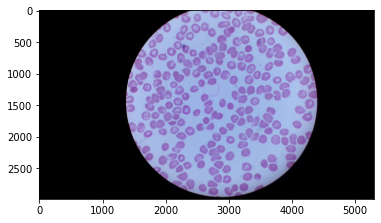

In [54]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
#img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
#img = cv2.flip(img, 1)
plt.imshow(img)

In [55]:
# cv2.circle(img, df_file['position'][240][0], 1, (0,255,0), 50)
# plt.imshow(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


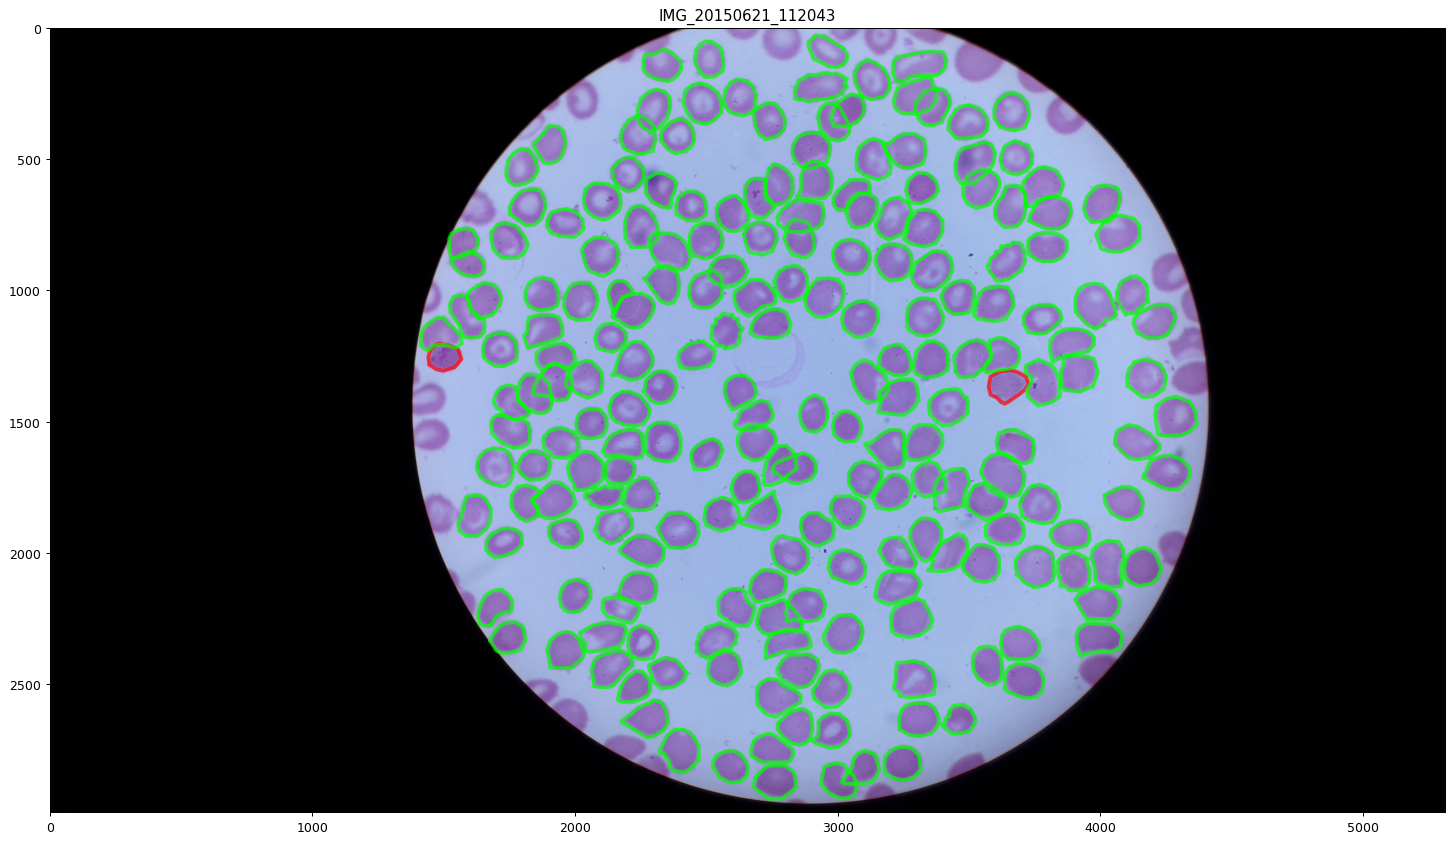

In [56]:
fig = plt.figure(1, figsize=(20,20), dpi=90)
df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row), axis = 1)
plt.imshow(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


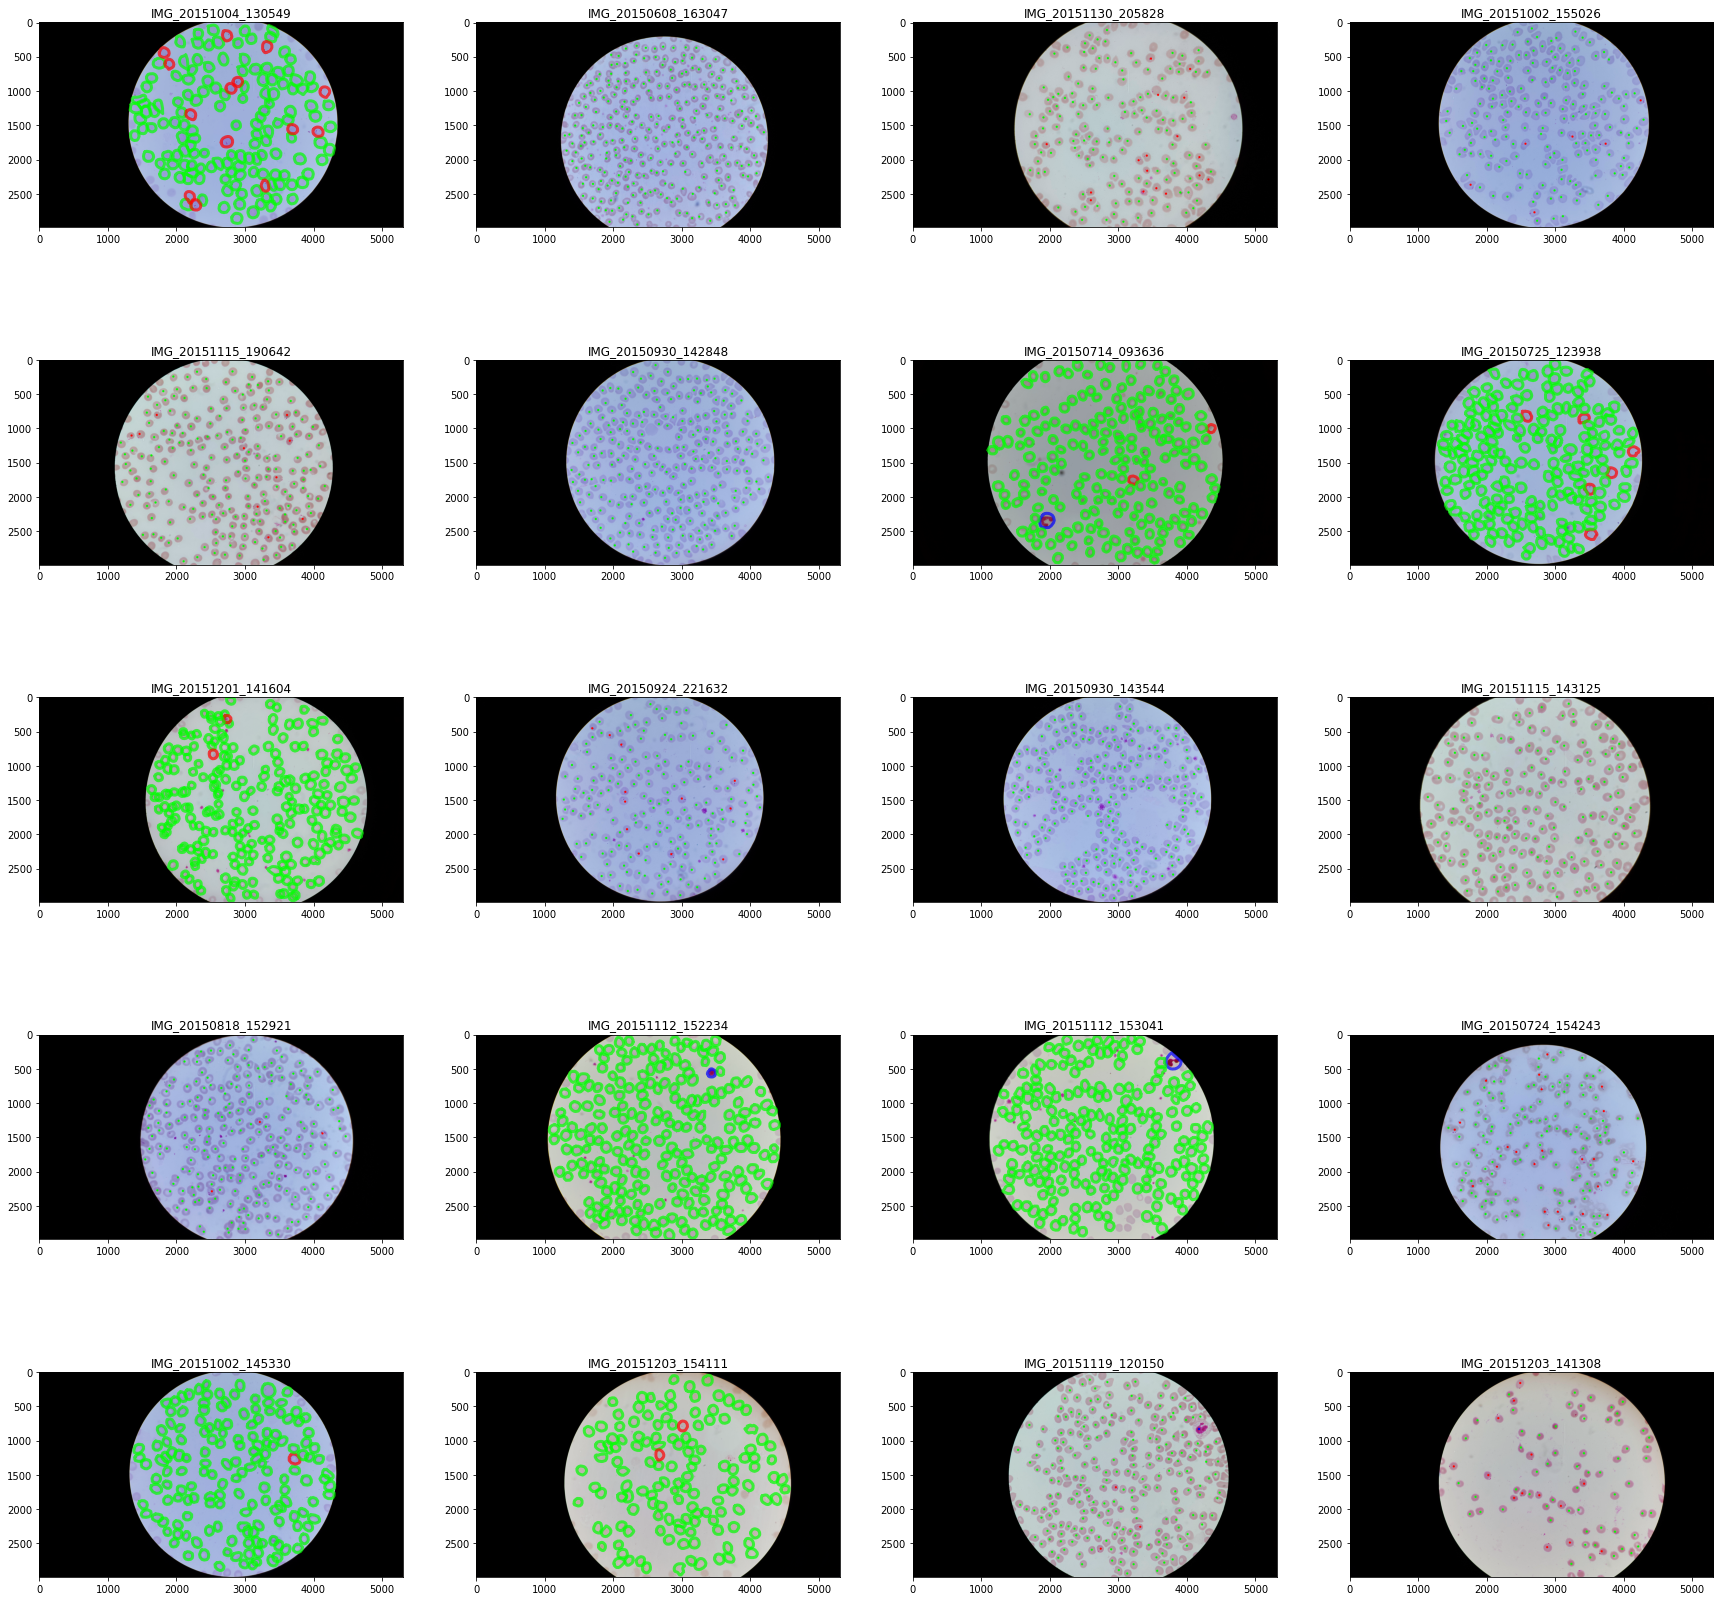

In [57]:
secure_random = random.SystemRandom()

w, h = 10, 10
fig=plt.figure(figsize=(30, 30))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    filename = secure_random.choice(df['filename'].unique())
    df_file = df[df['filename'] == filename]
    #print(filename)
    img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
    df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row = row, rows = rows, columns = columns, i = i, point_size= 30), axis = 1)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Polygons to mask

In [58]:
def poly_mask(row):
    poly = Polygon(row['position'])
    mask = poly.ravel().tolist()

In [59]:
filename =  'IMG_20151029_162934'

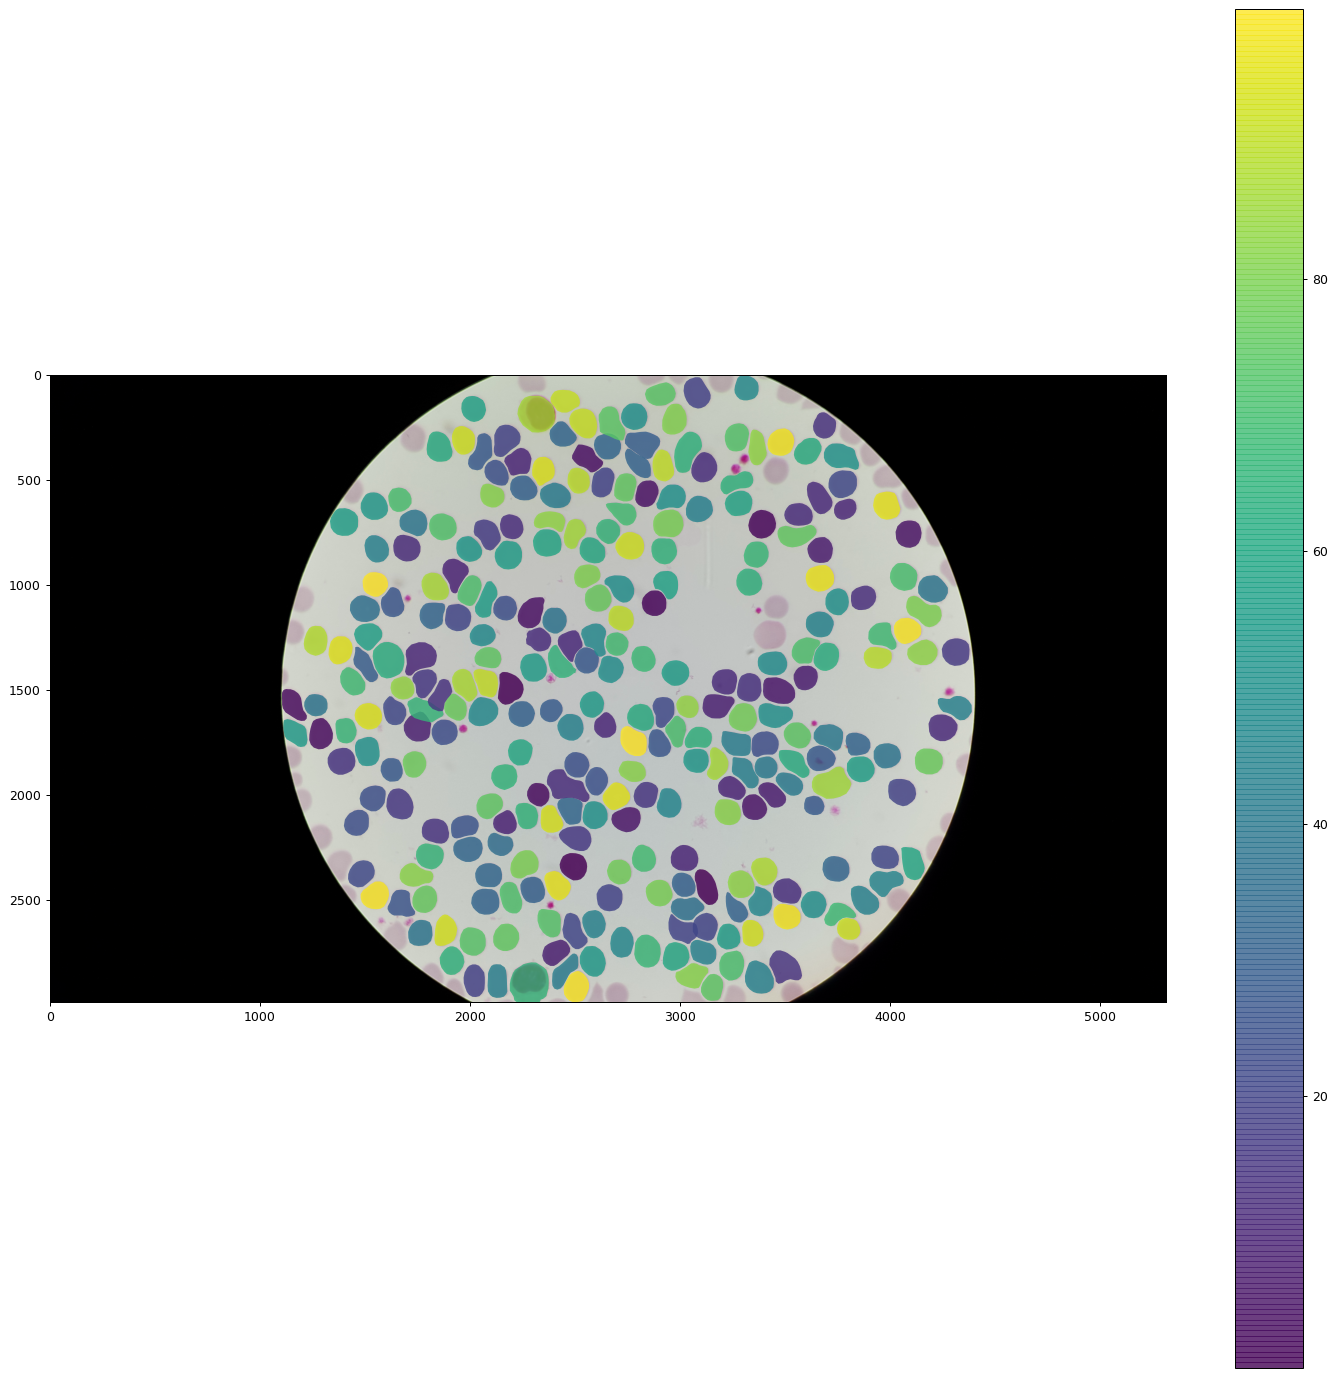

In [60]:
patches = []
patches = [ Polygon(poly) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position'] ]

img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)
empty_img = Image.new("L", [img.shape[1], img.shape[0]], 0)
mask = np.array(empty_img)

fig = plt.figure(1, figsize=(20,20), dpi=90)
ax = fig.add_subplot(111)

colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.8)
p.set_array(np.array(colors))
ax.add_collection(p)
fig.colorbar(p, ax=ax)
plt.imshow(img)

image shape:  <PIL.Image.Image image mode=1 size=5312x2988 at 0x7FF280DE8128>


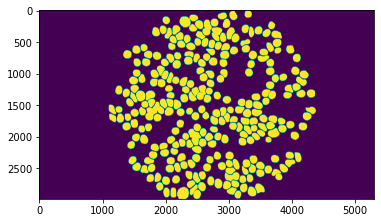

In [61]:
img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)

img = Image.new("L", [img.shape[1], img.shape[0]], 0)
img = img.convert('1')
print('image shape: ', img)
[ ImageDraw.Draw(img).polygon(poly, outline=1, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position']]
mask = np.array(img)

plt.imshow(mask)

img.save('Images/polygon_mask.png')

In [62]:
def poly2mask(filename):
    img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)
    img = Image.new("L", [img.shape[1], img.shape[0]], 0)
    img = img.convert('1')
    [ ImageDraw.Draw(img).polygon(poly, outline=0, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position']]
    # mask = np.array(img)
    # data = Image.fromarray(mask) 
    # # saving the final output  
    # # as a PNG file 
    # data = data.convert('1')
    # data.save(f'../masks/mask_{filename}.png')
    if not os.path.isdir('../masks'):
        os.makedirs('../masks')

    mask_path = f'../masks/mask_{filename}.png'
    img.save(mask_path)
    return mask, mask_path

In [63]:
filename =  'IMG_20150621_112043' #'IMG_20150623_134547' 
df_file = df[df['filename'] == filename]
df_file

Patient no - Cell no         cell     comment annotation_type  \
195475                  2-1  Parasitized  No_comment         Polygon   
195476                  2-2  Parasitized  No_comment         Polygon   
195477                  2-3   Uninfected  No_comment         Polygon   
195478                  2-4   Uninfected  No_comment         Polygon   
195479                  2-5   Uninfected  No_comment         Polygon   
...                     ...          ...         ...             ...   
195679                2-205   Uninfected  No_comment         Polygon   
195680                2-206   Uninfected  No_comment         Polygon   
195681                2-207   Uninfected  No_comment         Polygon   
195682                2-208   Uninfected  No_comment         Polygon   
195683                2-209   Uninfected  No_comment         Polygon   

       Number of points                                           position  \
195475               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
195476               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
195477               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
195478               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
195479               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   
...                 ...                                                ...   
195679               12  [(3293, 1312), (3289, 1277), (3303, 1227), (33...   
195680               21  [(3351, 1471), (3351, 1454), (3346, 1440), (33...   
195681               12  [(3259, 1631), (3259, 1594), (3271, 1552), (32...   
195682               18  [(3253, 1587), (3253, 1548), (3241, 1534), (32...   
195683               16  [(4166, 1704), (4176, 1688), (4184, 1664), (41...   

                   filename  \
195475  IMG_20150621_112043   
195476  IMG_20150621_112043   
195477  IMG_20150621_112043   
195478  IMG_20150621_112043   
195479  IMG_20150621_112043   
...                     ...   
195679  IMG_20150621_112043   
195680  IMG_20150621_112043   
195681  IMG_20150621_112043   
195682  IMG_20150621_112043   
195683  IMG_20150621_112043   

                                                 txt_path  \
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
...                                                   ...   
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   

                                                 img_path  
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
...                                                   ...  
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  

[209 rows x 9 columns]

## Connected Components

In [64]:
def connected_component_label(img):
    # https://iq.opengenus.org/connected-component-labeling/
    # https://stackoverflow.com/questions/13572448/replace-values-of-a-numpy-index-array-with-values-of-a-list


    num_labels, labels = cv2.connectedComponents(img)
    
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    palette = np.arange(1, 179)
    list_rand_nums = np.random.randint(1,179, 179)
    # list_rand_nums gives the new values you wish palette to be mapped to.
    index = np.digitize(label_hue.ravel(), palette, right=True)
    random_hue = np.uint8(list_rand_nums[index].reshape(label_hue.shape))

    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([random_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    
    # Showing Original Image
    plt.imshow(mask)
    plt.axis("off")
    plt.title("Orginal Image")
    plt.show()
    
    #Showing Image after Component Labeling
    plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGRA2RGB))
    plt.axis('off')
    plt.title("Image after Component Labeling")
    plt.show()

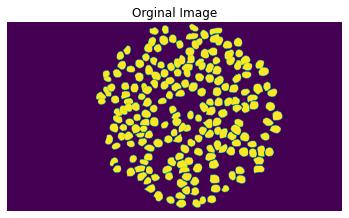

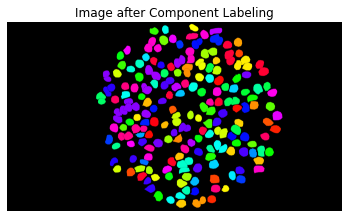

In [65]:
img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)
img = Image.new("L", [img.shape[1], img.shape[0]], 0)
#img = img.convert('1')
[ ImageDraw.Draw(img).polygon(poly, outline=0, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position']]
mask = np.array(img)
connected_component_label(mask)

In [66]:
num_labels, labels = cv2.connectedComponents(mask)
print(len(labels[0]))
print(np.max(labels))

5312
175


In [67]:
df

Patient no - Cell no         cell     comment annotation_type  \
0                       1-1  Parasitized  No_Comment           Point   
1                       1-2   Uninfected  No_Comment           Point   
2                       1-3   Uninfected  No_Comment           Point   
3                       1-4   Uninfected  No_Comment           Point   
4                       1-5   Uninfected  No_Comment           Point   
...                     ...          ...         ...             ...   
196929                4-167  Parasitized  No_comment         Polygon   
196930                4-168  Parasitized  No_comment         Polygon   
196931                4-169  Parasitized  No_comment         Polygon   
196932                4-170  Parasitized  No_comment         Polygon   
196933                4-171  Parasitized  No_comment         Polygon   

       Number of points                                           position  \
0                     1                                     [(2470, 1302)]   
1                     1                                      [(1598, 944)]   
2                     1                                      [(1756, 987)]   
3                     1                                      [(2000, 895)]   
4                     1                                     [(1938, 1006)]   
...                 ...                                                ...   
196929               25  [(2399, 383), (2404, 363), (2412, 351), (2426,...   
196930               21  [(3522, 2250), (3536, 2230), (3563, 2215), (35...   
196931               20  [(3321, 2138), (3335, 2114), (3347, 2103), (33...   
196932               20  [(3433, 1867), (3441, 1845), (3455, 1831), (34...   
196933               17  [(1432, 1762), (1438, 1739), (1456, 1719), (14...   

                   filename  \
0       IMG_20150918_161508   
1       IMG_20150918_161508   
2       IMG_20150918_161508   
3       IMG_20150918_161508   
4       IMG_20150918_161508   
...                     ...   
196929  IMG_20151004_131030   
196930  IMG_20151004_131030   
196931  IMG_20151004_131030   
196932  IMG_20151004_131030   
196933  IMG_20151004_131030   

                                                 txt_path  \
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
...                                                   ...   
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   

                                                 img_path  
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
...                                                   ...  
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  

[196934 rows x 9 columns]

In [68]:
def get_bbx(position, annotation_type, bb_pixel):
    if annotation_type == 'Polygon':
        poly_list = np.array([list(ele) for ele in position])
        x_min = np.nanmin(poly_list[:, 0])
        x_max = np.nanmax(poly_list[:, 0])
        y_min = np.nanmin(poly_list[:, 1])
        y_max = np.nanmax(poly_list[:, 1])
        return [x_min, y_min, x_max, y_max]
    if annotation_type == 'Point':
        point_list = np.array(position)
        x_min = int(point_list[:, 0] - 0.5 * bb_pixel)
        x_max = int(point_list[:, 0] + 0.5 * bb_pixel)
        y_min = int(point_list[:, 1] - 0.5 * bb_pixel)
        y_max = int(point_list[:, 1] + 0.5 * bb_pixel)
        return [x_min, y_min, x_max, y_max]

In [69]:
df['bbx'] = df.apply(lambda row: get_bbx(row['position'], row['annotation_type'], 140), axis = 1)
df

Patient no - Cell no         cell     comment annotation_type  \
0                       1-1  Parasitized  No_Comment           Point   
1                       1-2   Uninfected  No_Comment           Point   
2                       1-3   Uninfected  No_Comment           Point   
3                       1-4   Uninfected  No_Comment           Point   
4                       1-5   Uninfected  No_Comment           Point   
...                     ...          ...         ...             ...   
196929                4-167  Parasitized  No_comment         Polygon   
196930                4-168  Parasitized  No_comment         Polygon   
196931                4-169  Parasitized  No_comment         Polygon   
196932                4-170  Parasitized  No_comment         Polygon   
196933                4-171  Parasitized  No_comment         Polygon   

       Number of points                                           position  \
0                     1                                     [(2470, 1302)]   
1                     1                                      [(1598, 944)]   
2                     1                                      [(1756, 987)]   
3                     1                                      [(2000, 895)]   
4                     1                                     [(1938, 1006)]   
...                 ...                                                ...   
196929               25  [(2399, 383), (2404, 363), (2412, 351), (2426,...   
196930               21  [(3522, 2250), (3536, 2230), (3563, 2215), (35...   
196931               20  [(3321, 2138), (3335, 2114), (3347, 2103), (33...   
196932               20  [(3433, 1867), (3441, 1845), (3455, 1831), (34...   
196933               17  [(1432, 1762), (1438, 1739), (1456, 1719), (14...   

                   filename  \
0       IMG_20150918_161508   
1       IMG_20150918_161508   
2       IMG_20150918_161508   
3       IMG_20150918_161508   
4       IMG_20150918_161508   
...                     ...   
196929  IMG_20151004_131030   
196930  IMG_20151004_131030   
196931  IMG_20151004_131030   
196932  IMG_20151004_131030   
196933  IMG_20151004_131030   

                                                 txt_path  \
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
...                                                   ...   
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   

                                                 img_path  \
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
...                                                   ...   
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   

                             bbx  
0       [2400, 1232, 2540, 1372]  
1        [1528, 874, 1668, 1014]  
2        [1686, 917, 1826, 1057]  
3         [1930, 825, 2070, 965]  
4        [1868, 936, 2008, 1076]  
...                          ...  
196929    [2389, 328, 2516, 490]  
196930  [3516, 2212, 3675, 2345]  
196931  [3318, 2086, 3469, 2235]  
196932  [3431, 1

## Tiling images and labels

(2988, 5312)


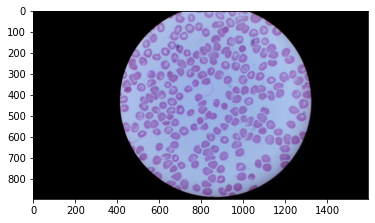

In [70]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
resize_factor = .3
print(img.shape[:2])
resized_img = cv2.resize(img, (int(round(img.shape[1] * resize_factor)), int(round(img.shape[0] * resize_factor))), interpolation=cv2.INTER_AREA)
plt.imshow(resized_img)

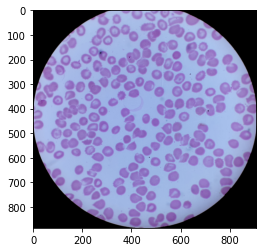

In [71]:
# select circle only
img_gray = rgb2gray(resized_img)
th = threshold_otsu(img_gray)
fg = img_gray>th
# Find the bounding box of those pixels
coords = np.array(np.nonzero(fg))
top_left = np.min(coords, axis=1)
bottom_right = np.max(coords, axis=1)

#set all under threshhold values to zero 
img_circle = resized_img*gray2rgb(fg)

img_cropped = img_circle[top_left[0]:bottom_right[0],
            top_left[1]:bottom_right[1]]

plt.imshow(img_cropped)

In [72]:
df_file

Patient no - Cell no         cell     comment annotation_type  \
195475                  2-1  Parasitized  No_comment         Polygon   
195476                  2-2  Parasitized  No_comment         Polygon   
195477                  2-3   Uninfected  No_comment         Polygon   
195478                  2-4   Uninfected  No_comment         Polygon   
195479                  2-5   Uninfected  No_comment         Polygon   
...                     ...          ...         ...             ...   
195679                2-205   Uninfected  No_comment         Polygon   
195680                2-206   Uninfected  No_comment         Polygon   
195681                2-207   Uninfected  No_comment         Polygon   
195682                2-208   Uninfected  No_comment         Polygon   
195683                2-209   Uninfected  No_comment         Polygon   

       Number of points                                           position  \
195475               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
195476               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
195477               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
195478               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
195479               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   
...                 ...                                                ...   
195679               12  [(3293, 1312), (3289, 1277), (3303, 1227), (33...   
195680               21  [(3351, 1471), (3351, 1454), (3346, 1440), (33...   
195681               12  [(3259, 1631), (3259, 1594), (3271, 1552), (32...   
195682               18  [(3253, 1587), (3253, 1548), (3241, 1534), (32...   
195683               16  [(4166, 1704), (4176, 1688), (4184, 1664), (41...   

                   filename  \
195475  IMG_20150621_112043   
195476  IMG_20150621_112043   
195477  IMG_20150621_112043   
195478  IMG_20150621_112043   
195479  IMG_20150621_112043   
...                     ...   
195679  IMG_20150621_112043   
195680  IMG_20150621_112043   
195681  IMG_20150621_112043   
195682  IMG_20150621_112043   
195683  IMG_20150621_112043   

                                                 txt_path  \
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
...                                                   ...   
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   

                                                 img_path  
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
...                                                   ...  
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  

[209 rows x 9 columns]

In [73]:
def plot_tiles(img, tile_w, tile_h):
    img_shape = img.shape
    tile_size = (tile_w, tile_h)
    offset = (tile_w, tile_h)

    for x in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
        #print(i)
        for y in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
            #print(j)
            #print((offset[1]*i, min(offset[1]*i+tile_size[1], img_shape[0])), (offset[0]*j, min(offset[0]*j+tile_size[0], img_shape[1])))
            x_min = min(offset[1] * x + tile_size[1], img_shape[0])
            x_max = offset[1] * x
            y_min = min(offset[0] * y + tile_size[0], img_shape[1])
            y_max = offset[0]*y
            cv2.rectangle(img, (x_max, x_min), (y_max, y_min), (0, 0, 255), 3)
            #cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
            # Debugging the tiles
            #cv2.imwrite("debug_" + str(i) + "_" + str(j) + ".png", cropped_img)
    plt.imshow(crop_img)

def crop_tiles(img, tile_w, tile_h):
    img_shape = img.shape
    tile_size = (tile_w, tile_h)
    offset = (tile_w, tile_h)
    for x in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
        for y in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
            x_min = offset[1] * x
            x_max = min(offset[1] * x + tile_size[1], img_shape[0])
            y_min = offset[0]*y
            y_max = min(offset[0] * y + tile_size[0], img_shape[1])
            crop_image = img[x_min : x_min + tile_w, y_min: y_min + tile_h]
            cv2.imwrite(f'../cropped/{x_min}_{x_max}_{y_min}_{y_max}.png', crop_image) 
    #plt.imshow(crop_image)


In [74]:
crop_tiles(img_cropped, 256, 256)

In [75]:
def convert_labels(path, x1, y1, x2, y2):
    """
    Definition: Parses label files to extract label and bounding box
        coordinates.  Converts (x1, y1, x1, y2) KITTI format to
        (x, y, width, height) normalized YOLO format.
    """
    def sorting(l1, l2):
        if l1 > l2:
            lmax, lmin = l1, l2
            return lmax, lmin
        else:
            lmax, lmin = l2, l1
            return lmax, lmin
    size = get_img_shape(path)
    xmax, xmin = sorting(x1, x2)
    ymax, ymin = sorting(y1, y2)
    dw = 1./size[1]
    dh = 1./size[0]
    x = (xmin + xmax)/2.0
    y = (ymin + ymax)/2.0
    w = xmax - xmin
    h = ymax - ymin
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

In [76]:
###############################################################################
def slice_img(input_im, input_mask, 
                     filename,
                    outdir_im, 
                     outdir_mask,
                     outdir_label,
                      classes_dic, 
                     category, 
                     box_coords, resize_factor = 1,
                  sliceHeight=256, sliceWidth=256,
                  zero_frac_thresh=0, overlap=0, pad=0, verbose = False,
                  box_coords_dir='', yolt_coords_dir='', create_mask = False):
    '''
    ADAPTED FROM YOLT/SCRIPTS/SLICE_IM.PY
    Assume input_im is rgb
    Slice large image into smaller pieces,
    ignore slices with a percentage null greater then zero_fract_thresh'''

    print('############# slice_img #############')
    img = cv2.imread(input_im, 1)  # color
    if create_mask == True:
        mask = cv2.imread(input_mask, 0)
    category_num = [classes_dic[k] for k in category] 

    resized_img = cv2.resize(img, (int(round(img.shape[1] * resize_factor)), int(round(img.shape[0] * resize_factor))))
    if create_mask == True:
        resized_mask = cv2.resize(mask, (int(round(mask.shape[1] * resize_factor)), int(round(mask.shape[0] * resize_factor))))
    resized_box_coords = np.array(np.round(np.array(box_coords) * np.array(resize_factor)).astype(int))


    im_h, im_w = resized_img.shape[:2]
    print('im_h', im_h)
    print('im_w', im_w)

    win_size = sliceHeight*sliceWidth

    # if slice sizes are large than image, pad the edges
    if sliceHeight > im_h:
        pad = sliceHeight - im_h
    if sliceWidth > im_w:
        pad = max(pad, sliceWidth - im_w)
    # pad the edge of the image with black pixels
    if pad > 0:
        border_color = (0, 0, 0)
        resized_img = cv2.copyMakeBorder(resized_img, pad, pad, pad, pad,
                                   cv2.BORDER_CONSTANT, value=border_color)
        if create_mask == True:
            resized_mask = cv2.copyMakeBorder(resized_img, pad, pad, pad, pad,
                                cv2.BORDER_CONSTANT, value=border_color)

    t0 = time.time()
    n_ims = 0
    n_ims_nonull = 0
    dx = int((1. - overlap) * sliceWidth)
    dy = int((1. - overlap) * sliceHeight)
    print('dx', dx)
    print('dy', dy)
    dict_yolo = {}
    dict_bbx = {}
    cut_imgs_name = []
    max_annot = 0
    bboxes = []
    

    for y in range(0, im_h, dy):  # sliceHeight):
        for x in range(0, im_w, dx):  # sliceWidth):
            n_ims += 1
            # extract image
            # make sure we don't go past the edge of the image
            if y + sliceHeight > im_h:
                y0 = im_h - sliceHeight
            else:
                y0 = y
            if x + sliceWidth > im_w:
                x0 = im_w - sliceWidth
            else:
                x0 = x

            window_c = resized_img[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
            if create_mask == True:
                window_mask = resized_mask[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
##           gt_c = gt_image[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
#             gt_c = image[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
            win_h, win_w = window_c.shape[:2]
    
            outname_part = 'slice_' + filename + \
            '_' + str(y0) + '_' + str(x0) + \
            '_' + str(win_h) + '_' + str(win_w) + \
            '_' + str(pad)

            if create_mask == True:
                outname_mask_part = 'slice_mask_' + filename + \
                    '_' + str(y0) + '_' + str(x0) + \
                    '_' + str(win_h) + '_' + str(win_w) + \
                    '_' + str(pad)
        
            # [x0, x1, y0, y1]


            # get black and white image
            window = cv2.cvtColor(window_c, cv2.COLOR_BGR2GRAY)

            # find threshold of image that's not black
            # https://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html?highlight=threshold
            ret, thresh1 = cv2.threshold(window, 2, 255, cv2.THRESH_BINARY)
            non_zero_counts = cv2.countNonZero(thresh1)
            zero_counts = win_size - non_zero_counts
            zero_frac = float(zero_counts) / win_size
            # print ("zero_frac", zero_fra
            # skip if image is mostly empty
            if zero_frac >= zero_frac_thresh:
                if verbose:
                    print("Zero frac too high at:", zero_frac)
                continue
                
            new_box_coords = []
            yolt_coords = []
            annot_count = 0

            #for box in resized_box_coords: 
            for box, cat in zip(resized_box_coords, category_num):
                if box[0] >= x0 and box[2] <= x0 + sliceHeight and box[1] >= y0 and box[3] <= y0 + sliceHeight:
                    box = np.asarray([box[0] - x0, box[1] - y0, box[2] - x0, box[3] - y0, cat])
                    new_box_coords.append(box)
                    annot_count += 1
                    # Input to convert: image size: (w,h), box: [x0, x1, y0, y1]
                    #print(box)
                    yolt_co_i = convert((win_w, win_h), box)
                    yolt_coords.append(yolt_co_i)
            
            if annot_count > max_annot:
                max_annot = annot_count

            #  save
            outname_im = os.path.join(outdir_im, outname_part + '.png')
            if create_mask == True:
                outname_mask = os.path.join(outdir_mask, outname_mask_part + '.png')
            txt_outpath = os.path.join(outdir_label, outname_part + '.txt')

            dict_yolo[outname_im] = yolt_coords
            dict_bbx[outname_im] = new_box_coords
            cut_imgs_name.append(outname_im)
            bboxes.append(np.asarray(new_box_coords))

            # save yolt ims
            if verbose:
                print("image output:", outname_im)
            cv2.imwrite(outname_im, window_c)
            if create_mask == True:
                cv2.imwrite(outname_mask, window_mask)

            # save yolt labels
            txt_outfile = open(txt_outpath, "w+")
            if verbose:
                print("txt output:" + txt_outpath)
            for bb in yolt_coords:
                outstring = str(category_num) + " " + \
                    " ".join([str(a) for a in bb]) + '\n'
                if verbose:
                    print("outstring:", outstring)
                txt_outfile.write(outstring)
            txt_outfile.close()

            # if desired, save coords files
            # save box coords dictionary so that yolt_eval.py can read it
            if len(box_coords_dir) > 0:
                coords_dic = gt_dic_from_box_coords(box_coords)
                outname_pkl = os.path.join(
                    box_coords_dir, outname_part + '_' + category + '.pkl')
                pickle.dump(coords_dic, open(outname_pkl, 'wb'), protocol=2)
            if len(yolt_coords_dir) > 0:
                outname_pkl = os.path.join(
                    yolt_coords_dir, outname_part + '_' + category + '.pkl')
                pickle.dump(yolt_coords, open(outname_pkl, 'wb'), protocol=2)

            n_ims_nonull += 1


    print("Num slices:", n_ims, "Num non-null slices:", n_ims_nonull,
          "sliceHeight", sliceHeight, "sliceWidth", sliceWidth)
    print("Time to slice", input_im, time.time()-t0, "seconds")

    return dict_yolo, dict_bbx, bboxes, cut_imgs_name, max_annot

def convert(size, box):
    '''Input = image size: (w,h), box: [x0, x1, y0, y1]'''
    dw = 1./size[0]
    dh = 1./size[1]
    xmid = (box[0] + box[1])/2.0
    ymid = (box[2] + box[3])/2.0
    w0 = box[1] - box[0]
    h0 = box[3] - box[2]
    x = xmid*dw
    y = ymid*dh
    w = w0*dw
    h = h0*dh
    return (x, y, w, h)

In [77]:
dict_mask = {}
dict_bbxs = {}
total_max_annot = 0
imgs_name = []
annots = np.array([])
mask_path = ''
outdir_mask = ''

for filename in df['filename'].unique():
    print(filename)
    create_mask = False
    if df.loc[(df['filename'] == filename),'annotation_type'].iloc[-1] ==  'Polygon':
        # first we create a black and white mask where the polygons are white
        mask, mask_path = poly2mask(filename)
        dict_mask[filename] = mask_path
        print(mask_path)
        # now lets slice the images (and bbx although we will proabaly not use them)
        filename = df.loc[(df['filename'] == filename),'filename'].iloc[-1]
        img_path = df.loc[(df['filename'] == filename),'img_path'].iloc[-1]
        
        if not os.path.isdir('../cropped'):
            os.makedirs('../cropped')

        outdir_im = f'../cropped/{filename}/img'
        outdir_mask = f'../cropped/{filename}/mask'
        outdir_label = f'../cropped/{filename}/labels'
        check_if_outdir_im = os.path.isdir(outdir_im)
        check_if_outdir_mask = os.path.isdir(outdir_mask)
        check_if_outdir_label = os.path.isdir(outdir_label)

        if not check_if_outdir_im:
            os.makedirs(outdir_im)
        if not check_if_outdir_mask:
            os.makedirs(outdir_mask)
        if not check_if_outdir_label:
            os.makedirs(outdir_label)
        create_mask = True

    else: 
        # now lets slice the images (and bbx although we will proabaly not use them)
        filename = df.loc[(df['filename'] == filename),'filename'].iloc[-1]
        img_path = df.loc[(df['filename'] == filename),'img_path'].iloc[-1]
        
        if not os.path.isdir('../cropped'):
            os.makedirs('../cropped')

        outdir_im = f'../cropped/{filename}/img'
        outdir_label = f'../cropped/{filename}/labels'
        check_if_outdir_im = os.path.isdir(outdir_im)
        check_if_outdir_label = os.path.isdir(outdir_label)

        if not check_if_outdir_im:
            os.makedirs(outdir_im)
        if not check_if_outdir_label:
            os.makedirs(outdir_label)

    slice_height = 256
    slice_width = 256
    resize_factor = 0.3
    classes_dic = {'Uninfected': 0, 'Parasitized': 1, 'White_Blood_Cell': 2}
    box_coords = df.loc[(df['filename'] == filename),'bbx'].tolist()
    category = df.loc[(df['filename'] == filename),'cell'].tolist()

    dict_yolo, dict_bbx, \
    bboxes, cut_imgs_name, \
        max_annot = slice_img(img_path, mask_path, 
                            filename,
                            outdir_im, 
                            outdir_mask, 
                            outdir_label,
                            classes_dic, 
                            category, 
                            box_coords, 
                        sliceHeight= slice_height, sliceWidth=slice_width,
                        resize_factor = resize_factor,
                        zero_frac_thresh=0.9, overlap=0, pad=0, verbose=False,
                        box_coords_dir='', yolt_coords_dir='', create_mask = create_mask)

    if max_annot > total_max_annot:
        total_max_annot = max_annot

    dict_bbxs.update(dict_bbx)
    annots = np.append(annots, bboxes)
    imgs_name += cut_imgs_name


IMG_20150918_161508
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 14 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102P63ThinF/Img/IMG_20150918_161508.jpg 0.05616164207458496 seconds
IMG_20150918_162300
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 14 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102P63ThinF/Img/IMG_20150918_162300.jpg 0.0552060604095459 seconds
IMG_20150918_162051
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102P63ThinF/Img/IMG_20150918_162051.jpg 0.0543370246887207 seconds
IMG_20150918_161826
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 14 sliceHeight 25

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/324C232ThinF/Img/IMG_20151112_154424.jpg 0.06722426414489746 seconds
IMG_20151201_105354
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 19 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/352C167P128ReThinF/Img/IMG_20151201_105354.jpg 0.07317447662353516 seconds
IMG_20151201_110011
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 22 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/352C167P128ReThinF/Img/IMG_20151201_110011.jpg 0.07951164245605469 seconds
IMG_20151201_105707
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 19 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSm

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/356C171P132ThinF/Img/IMG_20151119_153347.jpg 0.06415414810180664 seconds
IMG_20151119_153425
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/356C171P132ThinF/Img/IMG_20151119_153425.jpg 0.06454730033874512 seconds
IMG_20151115_123837
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/335C152P113ThinF/Img/IMG_20151115_123837.jpg 0.05787467956542969 seconds
IMG_20151115_124032
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSm

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/216C75P36_ThinF/Img/IMG_20150815_163225.jpg 0.05875086784362793 seconds
IMG_20150815_163015
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/216C75P36_ThinF/Img/IMG_20150815_163015.jpg 0.05649209022521973 seconds
IMG_20150815_163059
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/216C75P36_ThinF/Img/IMG_20150815_163059.jpg 0.054986000061035156 seconds
IMG_20151127_115306
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmea

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/234C92P53ThinF/Img/IMG_20150821_150457.jpg 0.06280708312988281 seconds
IMG_20150821_151646
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/234C92P53ThinF/Img/IMG_20150821_151646.jpg 0.06042981147766113 seconds
IMG_20150821_151722
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/234C92P53ThinF/Img/IMG_20150821_151722.jpg 0.06187915802001953 seconds
IMG_20150821_151224
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/241C2NThinF/Img/IMG_20150604_114815.jpg 0.058264970779418945 seconds
IMG_20150604_114631
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/241C2NThinF/Img/IMG_20150604_114631.jpg 0.06097698211669922 seconds
IMG_20150604_114751
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/241C2NThinF/Img/IMG_20150604_114751.jpg 0.0589444637298584 seconds
IMG_20150604_115238
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Se

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 14 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/252C104P65ThinF/Img/IMG_20150918_172053.jpg 0.056416988372802734 seconds
IMG_20151118_155802
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/353C168P129ThinF/Img/IMG_20151118_155802.jpg 0.057067155838012695 seconds
IMG_20151118_160516
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/353C168P129ThinF/Img/IMG_20151118_160516.jpg 0.06185317039489746 seconds
IMG_20151118_153739
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodS

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/148C47P8thinOriginalOlympusCX21/Img/IMG_20150717_173432.jpg 0.05542898178100586 seconds
IMG_20150717_172748
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/148C47P8thinOriginalOlympusCX21/Img/IMG_20150717_172748.jpg 0.06294941902160645 seconds
IMG_20150930_171739
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 14 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/264C116P77ThinF/Img/IMG_20150930_171739.jpg 0.053193092346191406 seconds
IMG_20150930_171448
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 14 sliceHeight 256 sliceWidth 256
Time t

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/333C150P111ThinF/Img/IMG_20151115_115922.jpg 0.06428885459899902 seconds
IMG_20151115_120029
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/333C150P111ThinF/Img/IMG_20151115_120029.jpg 0.06332254409790039 seconds
IMG_20151115_115805
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/333C150P111ThinF/Img/IMG_20151115_115805.jpg 0.06307196617126465 seconds
IMG_20150818_112518
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSm

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 18 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/311C218ThinF/Img/IMG_20151106_144001.jpg 0.06666064262390137 seconds
IMG_20151106_144337
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/311C218ThinF/Img/IMG_20151106_144337.jpg 0.06258583068847656 seconds
IMG_20151106_144143
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/311C218ThinF/Img/IMG_20151106_144143.jpg 0.06348109245300293 seconds
IMG_20151106_143940
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 18 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/258C110P71ThinF/Img/IMG_20150930_105319.jpg 0.054784297943115234 seconds
IMG_20150930_105559
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/258C110P71ThinF/Img/IMG_20150930_105559.jpg 0.055838584899902344 seconds
IMG_20150930_110052
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/258C110P71ThinF/Img/IMG_20150930_110052.jpg 0.060547828674316406 seconds
IMG_20150930_105729
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSm

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 14 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/267C119P80ThinF/Img/IMG_20151002_122720.jpg 0.05042290687561035 seconds
IMG_20151106_160304
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/314C221ThinF/Img/IMG_20151106_160304.jpg 0.06427526473999023 seconds
IMG_20151106_160515
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/314C221ThinF/Img/IMG_20151106_160515.jpg 0.0608220100402832 seconds
IMG_20151106_160653
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Poi

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/304C211ThinF/Img/IMG_20151029_164248.jpg 0.06262350082397461 seconds
IMG_20151029_163959
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/304C211ThinF/Img/IMG_20151029_163959.jpg 0.06694507598876953 seconds
IMG_20150818_101412
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/226C84P45ThinF/Img/IMG_20150818_101412.jpg 0.05019998550415039 seconds
IMG_20150818_101257
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Poi

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/347C164P125ThinF/Img/IMG_20151116_113550.jpg 0.0598607063293457 seconds
IMG_20151116_115112
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/347C164P125ThinF/Img/IMG_20151116_115112.jpg 0.058831214904785156 seconds
IMG_20151116_113954
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/347C164P125ThinF/Img/IMG_20151116_113954.jpg 0.056554317474365234 seconds
IMG_20151106_114526
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodS

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 19 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/363C178P139NThinF/Img/IMG_20151201_154337.jpg 0.062439680099487305 seconds
IMG_20151201_154025
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 19 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/363C178P139NThinF/Img/IMG_20151201_154025.jpg 0.0625147819519043 seconds
IMG_20151201_151903
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 19 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/363C178P139NThinF/Img/IMG_20151201_151903.jpg 0.05960559844970703 seconds
IMG_20151201_153246
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 19 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloo

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/240C13NThinF/Img/IMG_20150614_131529.jpg 0.06652307510375977 seconds
IMG_20150614_131417
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/240C13NThinF/Img/IMG_20150614_131417.jpg 0.05860090255737305 seconds
IMG_20150614_131553
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/240C13NThinF/Img/IMG_20150614_131553.jpg 0.059762001037597656 seconds
IMG_20150614_131457
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Poin

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/144C3thin_original/Img/IMG_20150608_163002.jpg 0.06087374687194824 seconds
IMG_20151002_130715
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 14 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/268C120P81ThinF/Img/IMG_20151002_130715.jpg 0.051392555236816406 seconds
IMG_20151002_125443
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 14 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/268C120P81ThinF/Img/IMG_20151002_125443.jpg 0.04844307899475098 seconds
IMG_20151002_130918
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 14 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodS

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 14 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/284C136P97ThinF/Img/IMG_20151005_140538.jpg 0.04728221893310547 seconds
IMG_20151005_141803
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 14 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/284C136P97ThinF/Img/IMG_20151005_141803.jpg 0.04723381996154785 seconds
IMG_20151112_150329
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/322C230ThinF/Img/IMG_20151112_150329.jpg 0.06659460067749023 seconds
IMG_20151112_150753
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/293C145P106ThinF/Img/IMG_20151016_154641.jpg 0.05623459815979004 seconds
IMG_20151016_154756
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 18 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/293C145P106ThinF/Img/IMG_20151016_154756.jpg 0.05790543556213379 seconds
IMG_20151016_154844
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/293C145P106ThinF/Img/IMG_20151016_154844.jpg 0.059272050857543945 seconds
IMG_20151112_103809
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodS

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/341C158P119ThinF/Img/IMG_20151115_181436.jpg 0.06028890609741211 seconds
IMG_20151115_181035
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/341C158P119ThinF/Img/IMG_20151115_181035.jpg 0.06035661697387695 seconds
IMG_20151115_181859
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/341C158P119ThinF/Img/IMG_20151115_181859.jpg 0.06209397315979004 seconds
IMG_20151115_181136
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSm

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/204C63P24N_ThinF/Img/IMG_20150818_143423.jpg 0.056928396224975586 seconds
IMG_20150818_143757
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/204C63P24N_ThinF/Img/IMG_20150818_143757.jpg 0.05950570106506348 seconds
IMG_20150818_143544
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/204C63P24N_ThinF/Img/IMG_20150818_143544.jpg 0.05743288993835449 seconds
IMG_20150818_143319
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodS

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 18 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/312C219ThinF/Img/IMG_20151106_150135.jpg 0.06667590141296387 seconds
IMG_20151106_151622
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/303C205ThinF/Img/IMG_20151106_151622.jpg 0.06147336959838867 seconds
IMG_20151106_151800
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/303C205ThinF/Img/IMG_20151106_151800.jpg 0.06438851356506348 seconds
IMG_20151106_152003
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 18 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/238C96P57ThinF/Img/IMG_20150824_110812.jpg 0.054085731506347656 seconds
IMG_20150824_111748
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/238C96P57ThinF/Img/IMG_20150824_111748.jpg 0.056153059005737305 seconds
IMG_20151112_142216
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/320C228ThinF/Img/IMG_20151112_142216.jpg 0.06746125221252441 seconds
IMG_20151112_142452
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/147C4thin_original/Img/IMG_20150608_165540.jpg 0.05892467498779297 seconds
IMG_20150608_165620
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/147C4thin_original/Img/IMG_20150608_165620.jpg 0.05814337730407715 seconds
IMG_20150608_165908
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/147C4thin_original/Img/IMG_20150608_165908.jpg 0.0590059757232666 seconds
IMG_20150924_103636
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBl

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/359C174P135NThinF/Img/IMG_20151127_135311.jpg 0.06182599067687988 seconds
IMG_20151127_135342
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/359C174P135NThinF/Img/IMG_20151127_135342.jpg 0.06356978416442871 seconds
IMG_20151127_135554
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/359C174P135NThinF/Img/IMG_20151127_135554.jpg 0.0619046688079834 seconds
IMG_20151127_135435
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBlood

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/326C234ThinF/Img/IMG_20151112_162940.jpg 0.06821680068969727 seconds
IMG_20151112_162759
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/326C234ThinF/Img/IMG_20151112_162759.jpg 0.06529092788696289 seconds
IMG_20151112_162843
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/326C234ThinF/Img/IMG_20151112_162843.jpg 0.06654477119445801 seconds
IMG_20151112_163036
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/145C42P5thin_original/Img/IMG_20150623_134919.jpg 0.05459022521972656 seconds
IMG_20150820_151451
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/230C88P49ThinF/Img/IMG_20150820_151451.jpg 0.05605888366699219 seconds
IMG_20150820_151626
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/230C88P49ThinF/Img/IMG_20150820_151626.jpg 0.054982662200927734 seconds
IMG_20150820_150724
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBlood

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 14 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/245C97P58ThinF/Img/IMG_20150917_151512.jpg 0.0510103702545166 seconds
IMG_20150917_150838
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 14 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/245C97P58ThinF/Img/IMG_20150917_150838.jpg 0.048294782638549805 seconds
IMG_20150821_171701
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Point Set/237C95P56ThinF/Img/IMG_20150821_171701.jpg 0.04919600486755371 seconds
IMG_20150821_171603
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf

../masks/mask_IMG_20151029_162605.png
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/302C210ThinF/Img/IMG_20151029_162605.jpg 0.07913756370544434 seconds
IMG_20151029_162834
../masks/mask_IMG_20151029_162834.png
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/302C210ThinF/Img/IMG_20151029_162834.jpg 0.0774533748626709 seconds
IMG_20151029_162439
../masks/mask_IMG_20151029_162439.png
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/302C210ThinF/Img/IMG_20151029_162439.jpg 0.07819509506225586 seconds
IMG_20151029_162934
../masks/mask_IMG_20151029_16293

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/209C68P29N_ThinF/Img/IMG_20150819_133350.jpg 0.07233262062072754 seconds
IMG_20150819_133447
../masks/mask_IMG_20150819_133447.png
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/209C68P29N_ThinF/Img/IMG_20150819_133447.jpg 0.07130980491638184 seconds
IMG_20150819_134112
../masks/mask_IMG_20150819_134112.png
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/209C68P29N_ThinF/Img/IMG_20150819_134112.jpg 0.0685889720916748 seconds
IMG_20150819_134326
../masks/mask_IMG_20150819_134326.png
############# slice_img #############
im_h 896
im_w 1594
d

../masks/mask_IMG_20150728_121151.png
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/156C55P16thinF/Img/IMG_20150728_121151.jpg 0.06294965744018555 seconds
IMG_20150728_121350
../masks/mask_IMG_20150728_121350.png
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/156C55P16thinF/Img/IMG_20150728_121350.jpg 0.06935286521911621 seconds
IMG_20150728_123510
../masks/mask_IMG_20150728_123510.png
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/156C55P16thinF/Img/IMG_20150728_123510.jpg 0.06976819038391113 seconds
IMG_20151112_153147
../masks/mask_IMG_2015111

../masks/mask_IMG_20150820_162813.png
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/231C89P50ThinF/Img/IMG_20150820_162813.jpg 0.0703132152557373 seconds
IMG_20150820_162153
../masks/mask_IMG_20150820_162153.png
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/231C89P50ThinF/Img/IMG_20150820_162153.jpg 0.06757545471191406 seconds
IMG_20150611_104753
../masks/mask_IMG_20150611_104753.png
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/244C7NthinF/Img/IMG_20150611_104753.jpg 0.06803178787231445 seconds
IMG_20150611_104609
../masks/mask_IMG_20150611_10

../masks/mask_IMG_20150729_111518.png
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/158C57P18thinF/Img/IMG_20150729_111518.jpg 0.07622408866882324 seconds
IMG_20151112_164918
../masks/mask_IMG_20151112_164918.png
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 16 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/327C235ThinF/Img/IMG_20151112_164918.jpg 0.07735347747802734 seconds
IMG_20151112_165055
../masks/mask_IMG_20151112_165055.png
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 17 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/327C235ThinF/Img/IMG_20151112_165055.jpg 0.08156251907348633 seconds
IMG_20151112_164834
../masks/mask_IMG_20151112_16

im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 15 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/150C49P10thinF/Img/IMG_20150724_103054.jpg 0.0678408145904541 seconds
IMG_20151203_153410
../masks/mask_IMG_20151203_153410.png
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 19 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/372C187P148NThinF/Img/IMG_20151203_153410.jpg 0.07457518577575684 seconds
IMG_20151203_153713
../masks/mask_IMG_20151203_153713.png
############# slice_img #############
im_h 896
im_w 1594
dx 256
dy 256
Num slices: 28 Num non-null slices: 18 sliceHeight 256 sliceWidth 256
Time to slice ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/372C187P148NThinF/Img/IMG_20151203_153713.jpg 0.07588839530944824 seconds
IMG_20151203_154111
../masks/mask_IMG_20151203_154111.png
############# slice_img #############
im_h 896
im_w 1594
d

In [78]:
df['mask_path'] = df['filename'].map(dict_mask)

In [79]:
imgs_name = np.array(imgs_name)
true_boxes = np.zeros((imgs_name.shape[0], total_max_annot, 5))
print('imgs_name.shape: ', imgs_name.shape)
print('max_annot: ', max_annot)
print('len annots: ', len(annots))
print('true_boxes shape: ', true_boxes.shape)
for idx, boxes in enumerate(annots):
    #print('boxes: ', boxes)
    print('boxes shape: ', boxes.shape)
    print('idx: ', idx)
    if len(boxes) == 0:
        boxes = np.asarray([0,0,0,0,0])
    true_boxes[idx, :boxes.shape[0], :5] = boxes

imgs_name.shape:  (15381,)
max_annot:  18
len annots:  15381
true_boxes shape:  (15381, 30, 5)
boxes shape:  (13, 5)
idx:  0
boxes shape:  (14, 5)
idx:  1
boxes shape:  (6, 5)
idx:  2
boxes shape:  (6, 5)
idx:  3
boxes shape:  (21, 5)
idx:  4
boxes shape:  (20, 5)
idx:  5
boxes shape:  (13, 5)
idx:  6
boxes shape:  (4, 5)
idx:  7
boxes shape:  (18, 5)
idx:  8
boxes shape:  (16, 5)
idx:  9
boxes shape:  (9, 5)
idx:  10
boxes shape:  (12, 5)
idx:  11
boxes shape:  (13, 5)
idx:  12
boxes shape:  (4, 5)
idx:  13
boxes shape:  (12, 5)
idx:  14
boxes shape:  (15, 5)
idx:  15
boxes shape:  (8, 5)
idx:  16
boxes shape:  (6, 5)
idx:  17
boxes shape:  (13, 5)
idx:  18
boxes shape:  (19, 5)
idx:  19
boxes shape:  (18, 5)
idx:  20
boxes shape:  (3, 5)
idx:  21
boxes shape:  (12, 5)
idx:  22
boxes shape:  (17, 5)
idx:  23
boxes shape:  (8, 5)
idx:  24
boxes shape:  (5, 5)
idx:  25
boxes shape:  (18, 5)
idx:  26
boxes shape:  (7, 5)
idx:  27
boxes shape:  (0,)
idx:  28
boxes shape:  (10, 5)
idx:  29

boxes shape:  (18, 5)
idx:  509
boxes shape:  (17, 5)
idx:  510
boxes shape:  (7, 5)
idx:  511
boxes shape:  (4, 5)
idx:  512
boxes shape:  (12, 5)
idx:  513
boxes shape:  (13, 5)
idx:  514
boxes shape:  (13, 5)
idx:  515
boxes shape:  (2, 5)
idx:  516
boxes shape:  (1, 5)
idx:  517
boxes shape:  (10, 5)
idx:  518
boxes shape:  (18, 5)
idx:  519
boxes shape:  (15, 5)
idx:  520
boxes shape:  (2, 5)
idx:  521
boxes shape:  (1, 5)
idx:  522
boxes shape:  (16, 5)
idx:  523
boxes shape:  (22, 5)
idx:  524
boxes shape:  (16, 5)
idx:  525
boxes shape:  (6, 5)
idx:  526
boxes shape:  (5, 5)
idx:  527
boxes shape:  (16, 5)
idx:  528
boxes shape:  (22, 5)
idx:  529
boxes shape:  (12, 5)
idx:  530
boxes shape:  (3, 5)
idx:  531
boxes shape:  (0,)
idx:  532
boxes shape:  (14, 5)
idx:  533
boxes shape:  (16, 5)
idx:  534
boxes shape:  (11, 5)
idx:  535
boxes shape:  (2, 5)
idx:  536
boxes shape:  (10, 5)
idx:  537
boxes shape:  (20, 5)
idx:  538
boxes shape:  (14, 5)
idx:  539
boxes shape:  (0,)
id

boxes shape:  (9, 5)
idx:  1086
boxes shape:  (17, 5)
idx:  1087
boxes shape:  (14, 5)
idx:  1088
boxes shape:  (3, 5)
idx:  1089
boxes shape:  (18, 5)
idx:  1090
boxes shape:  (17, 5)
idx:  1091
boxes shape:  (17, 5)
idx:  1092
boxes shape:  (6, 5)
idx:  1093
boxes shape:  (4, 5)
idx:  1094
boxes shape:  (14, 5)
idx:  1095
boxes shape:  (14, 5)
idx:  1096
boxes shape:  (19, 5)
idx:  1097
boxes shape:  (0,)
idx:  1098
boxes shape:  (9, 5)
idx:  1099
boxes shape:  (15, 5)
idx:  1100
boxes shape:  (14, 5)
idx:  1101
boxes shape:  (14, 5)
idx:  1102
boxes shape:  (13, 5)
idx:  1103
boxes shape:  (15, 5)
idx:  1104
boxes shape:  (4, 5)
idx:  1105
boxes shape:  (16, 5)
idx:  1106
boxes shape:  (18, 5)
idx:  1107
boxes shape:  (14, 5)
idx:  1108
boxes shape:  (3, 5)
idx:  1109
boxes shape:  (0,)
idx:  1110
boxes shape:  (1, 5)
idx:  1111
boxes shape:  (13, 5)
idx:  1112
boxes shape:  (16, 5)
idx:  1113
boxes shape:  (15, 5)
idx:  1114
boxes shape:  (1, 5)
idx:  1115
boxes shape:  (10, 5)
idx

boxes shape:  (5, 5)
idx:  1664
boxes shape:  (2, 5)
idx:  1665
boxes shape:  (9, 5)
idx:  1666
boxes shape:  (9, 5)
idx:  1667
boxes shape:  (2, 5)
idx:  1668
boxes shape:  (5, 5)
idx:  1669
boxes shape:  (12, 5)
idx:  1670
boxes shape:  (9, 5)
idx:  1671
boxes shape:  (7, 5)
idx:  1672
boxes shape:  (1, 5)
idx:  1673
boxes shape:  (7, 5)
idx:  1674
boxes shape:  (10, 5)
idx:  1675
boxes shape:  (5, 5)
idx:  1676
boxes shape:  (8, 5)
idx:  1677
boxes shape:  (7, 5)
idx:  1678
boxes shape:  (3, 5)
idx:  1679
boxes shape:  (7, 5)
idx:  1680
boxes shape:  (10, 5)
idx:  1681
boxes shape:  (5, 5)
idx:  1682
boxes shape:  (3, 5)
idx:  1683
boxes shape:  (9, 5)
idx:  1684
boxes shape:  (12, 5)
idx:  1685
boxes shape:  (10, 5)
idx:  1686
boxes shape:  (1, 5)
idx:  1687
boxes shape:  (7, 5)
idx:  1688
boxes shape:  (9, 5)
idx:  1689
boxes shape:  (4, 5)
idx:  1690
boxes shape:  (4, 5)
idx:  1691
boxes shape:  (7, 5)
idx:  1692
boxes shape:  (2, 5)
idx:  1693
boxes shape:  (14, 5)
idx:  1694
bo

boxes shape:  (21, 5)
idx:  2231
boxes shape:  (12, 5)
idx:  2232
boxes shape:  (14, 5)
idx:  2233
boxes shape:  (18, 5)
idx:  2234
boxes shape:  (15, 5)
idx:  2235
boxes shape:  (23, 5)
idx:  2236
boxes shape:  (0,)
idx:  2237
boxes shape:  (10, 5)
idx:  2238
boxes shape:  (14, 5)
idx:  2239
boxes shape:  (20, 5)
idx:  2240
boxes shape:  (18, 5)
idx:  2241
boxes shape:  (3, 5)
idx:  2242
boxes shape:  (18, 5)
idx:  2243
boxes shape:  (16, 5)
idx:  2244
boxes shape:  (12, 5)
idx:  2245
boxes shape:  (3, 5)
idx:  2246
boxes shape:  (18, 5)
idx:  2247
boxes shape:  (15, 5)
idx:  2248
boxes shape:  (11, 5)
idx:  2249
boxes shape:  (14, 5)
idx:  2250
boxes shape:  (19, 5)
idx:  2251
boxes shape:  (24, 5)
idx:  2252
boxes shape:  (15, 5)
idx:  2253
boxes shape:  (1, 5)
idx:  2254
boxes shape:  (9, 5)
idx:  2255
boxes shape:  (18, 5)
idx:  2256
boxes shape:  (13, 5)
idx:  2257
boxes shape:  (18, 5)
idx:  2258
boxes shape:  (3, 5)
idx:  2259
boxes shape:  (19, 5)
idx:  2260
boxes shape:  (14,

idx:  2799
boxes shape:  (16, 5)
idx:  2800
boxes shape:  (5, 5)
idx:  2801
boxes shape:  (11, 5)
idx:  2802
boxes shape:  (19, 5)
idx:  2803
boxes shape:  (7, 5)
idx:  2804
boxes shape:  (3, 5)
idx:  2805
boxes shape:  (12, 5)
idx:  2806
boxes shape:  (18, 5)
idx:  2807
boxes shape:  (16, 5)
idx:  2808
boxes shape:  (2, 5)
idx:  2809
boxes shape:  (15, 5)
idx:  2810
boxes shape:  (17, 5)
idx:  2811
boxes shape:  (13, 5)
idx:  2812
boxes shape:  (8, 5)
idx:  2813
boxes shape:  (15, 5)
idx:  2814
boxes shape:  (4, 5)
idx:  2815
boxes shape:  (10, 5)
idx:  2816
boxes shape:  (14, 5)
idx:  2817
boxes shape:  (10, 5)
idx:  2818
boxes shape:  (3, 5)
idx:  2819
boxes shape:  (12, 5)
idx:  2820
boxes shape:  (12, 5)
idx:  2821
boxes shape:  (12, 5)
idx:  2822
boxes shape:  (5, 5)
idx:  2823
boxes shape:  (2, 5)
idx:  2824
boxes shape:  (11, 5)
idx:  2825
boxes shape:  (13, 5)
idx:  2826
boxes shape:  (10, 5)
idx:  2827
boxes shape:  (0,)
idx:  2828
boxes shape:  (7, 5)
idx:  2829
boxes shape:

idx:  3369
boxes shape:  (14, 5)
idx:  3370
boxes shape:  (9, 5)
idx:  3371
boxes shape:  (0,)
idx:  3372
boxes shape:  (7, 5)
idx:  3373
boxes shape:  (11, 5)
idx:  3374
boxes shape:  (2, 5)
idx:  3375
boxes shape:  (2, 5)
idx:  3376
boxes shape:  (9, 5)
idx:  3377
boxes shape:  (13, 5)
idx:  3378
boxes shape:  (3, 5)
idx:  3379
boxes shape:  (3, 5)
idx:  3380
boxes shape:  (13, 5)
idx:  3381
boxes shape:  (14, 5)
idx:  3382
boxes shape:  (13, 5)
idx:  3383
boxes shape:  (2, 5)
idx:  3384
boxes shape:  (16, 5)
idx:  3385
boxes shape:  (15, 5)
idx:  3386
boxes shape:  (10, 5)
idx:  3387
boxes shape:  (0,)
idx:  3388
boxes shape:  (10, 5)
idx:  3389
boxes shape:  (10, 5)
idx:  3390
boxes shape:  (5, 5)
idx:  3391
boxes shape:  (1, 5)
idx:  3392
boxes shape:  (9, 5)
idx:  3393
boxes shape:  (9, 5)
idx:  3394
boxes shape:  (2, 5)
idx:  3395
boxes shape:  (5, 5)
idx:  3396
boxes shape:  (11, 5)
idx:  3397
boxes shape:  (10, 5)
idx:  3398
boxes shape:  (12, 5)
idx:  3399
boxes shape:  (4, 5

boxes shape:  (14, 5)
idx:  3944
boxes shape:  (12, 5)
idx:  3945
boxes shape:  (12, 5)
idx:  3946
boxes shape:  (11, 5)
idx:  3947
boxes shape:  (18, 5)
idx:  3948
boxes shape:  (20, 5)
idx:  3949
boxes shape:  (17, 5)
idx:  3950
boxes shape:  (0,)
idx:  3951
boxes shape:  (4, 5)
idx:  3952
boxes shape:  (19, 5)
idx:  3953
boxes shape:  (22, 5)
idx:  3954
boxes shape:  (15, 5)
idx:  3955
boxes shape:  (4, 5)
idx:  3956
boxes shape:  (19, 5)
idx:  3957
boxes shape:  (23, 5)
idx:  3958
boxes shape:  (5, 5)
idx:  3959
boxes shape:  (2, 5)
idx:  3960
boxes shape:  (13, 5)
idx:  3961
boxes shape:  (19, 5)
idx:  3962
boxes shape:  (10, 5)
idx:  3963
boxes shape:  (11, 5)
idx:  3964
boxes shape:  (18, 5)
idx:  3965
boxes shape:  (18, 5)
idx:  3966
boxes shape:  (16, 5)
idx:  3967
boxes shape:  (8, 5)
idx:  3968
boxes shape:  (19, 5)
idx:  3969
boxes shape:  (16, 5)
idx:  3970
boxes shape:  (16, 5)
idx:  3971
boxes shape:  (2, 5)
idx:  3972
boxes shape:  (16, 5)
idx:  3973
boxes shape:  (16, 

boxes shape:  (10, 5)
idx:  4509
boxes shape:  (1, 5)
idx:  4510
boxes shape:  (16, 5)
idx:  4511
boxes shape:  (13, 5)
idx:  4512
boxes shape:  (6, 5)
idx:  4513
boxes shape:  (5, 5)
idx:  4514
boxes shape:  (18, 5)
idx:  4515
boxes shape:  (16, 5)
idx:  4516
boxes shape:  (9, 5)
idx:  4517
boxes shape:  (1, 5)
idx:  4518
boxes shape:  (16, 5)
idx:  4519
boxes shape:  (12, 5)
idx:  4520
boxes shape:  (18, 5)
idx:  4521
boxes shape:  (12, 5)
idx:  4522
boxes shape:  (16, 5)
idx:  4523
boxes shape:  (4, 5)
idx:  4524
boxes shape:  (11, 5)
idx:  4525
boxes shape:  (12, 5)
idx:  4526
boxes shape:  (3, 5)
idx:  4527
boxes shape:  (7, 5)
idx:  4528
boxes shape:  (14, 5)
idx:  4529
boxes shape:  (22, 5)
idx:  4530
boxes shape:  (10, 5)
idx:  4531
boxes shape:  (1, 5)
idx:  4532
boxes shape:  (14, 5)
idx:  4533
boxes shape:  (19, 5)
idx:  4534
boxes shape:  (11, 5)
idx:  4535
boxes shape:  (11, 5)
idx:  4536
boxes shape:  (18, 5)
idx:  4537
boxes shape:  (8, 5)
idx:  4538
boxes shape:  (15, 5

idx:  5088
boxes shape:  (11, 5)
idx:  5089
boxes shape:  (15, 5)
idx:  5090
boxes shape:  (5, 5)
idx:  5091
boxes shape:  (1, 5)
idx:  5092
boxes shape:  (14, 5)
idx:  5093
boxes shape:  (13, 5)
idx:  5094
boxes shape:  (6, 5)
idx:  5095
boxes shape:  (6, 5)
idx:  5096
boxes shape:  (14, 5)
idx:  5097
boxes shape:  (10, 5)
idx:  5098
boxes shape:  (12, 5)
idx:  5099
boxes shape:  (0,)
idx:  5100
boxes shape:  (1, 5)
idx:  5101
boxes shape:  (12, 5)
idx:  5102
boxes shape:  (15, 5)
idx:  5103
boxes shape:  (12, 5)
idx:  5104
boxes shape:  (6, 5)
idx:  5105
boxes shape:  (14, 5)
idx:  5106
boxes shape:  (7, 5)
idx:  5107
boxes shape:  (10, 5)
idx:  5108
boxes shape:  (14, 5)
idx:  5109
boxes shape:  (6, 5)
idx:  5110
boxes shape:  (4, 5)
idx:  5111
boxes shape:  (13, 5)
idx:  5112
boxes shape:  (16, 5)
idx:  5113
boxes shape:  (13, 5)
idx:  5114
boxes shape:  (1, 5)
idx:  5115
boxes shape:  (13, 5)
idx:  5116
boxes shape:  (15, 5)
idx:  5117
boxes shape:  (16, 5)
idx:  5118
boxes shape:

idx:  5641
boxes shape:  (0,)
idx:  5642
boxes shape:  (7, 5)
idx:  5643
boxes shape:  (10, 5)
idx:  5644
boxes shape:  (12, 5)
idx:  5645
boxes shape:  (0,)
idx:  5646
boxes shape:  (3, 5)
idx:  5647
boxes shape:  (8, 5)
idx:  5648
boxes shape:  (8, 5)
idx:  5649
boxes shape:  (6, 5)
idx:  5650
boxes shape:  (3, 5)
idx:  5651
boxes shape:  (3, 5)
idx:  5652
boxes shape:  (1, 5)
idx:  5653
boxes shape:  (7, 5)
idx:  5654
boxes shape:  (13, 5)
idx:  5655
boxes shape:  (7, 5)
idx:  5656
boxes shape:  (0,)
idx:  5657
boxes shape:  (0,)
idx:  5658
boxes shape:  (8, 5)
idx:  5659
boxes shape:  (12, 5)
idx:  5660
boxes shape:  (7, 5)
idx:  5661
boxes shape:  (1, 5)
idx:  5662
boxes shape:  (5, 5)
idx:  5663
boxes shape:  (7, 5)
idx:  5664
boxes shape:  (8, 5)
idx:  5665
boxes shape:  (7, 5)
idx:  5666
boxes shape:  (11, 5)
idx:  5667
boxes shape:  (9, 5)
idx:  5668
boxes shape:  (1, 5)
idx:  5669
boxes shape:  (12, 5)
idx:  5670
boxes shape:  (13, 5)
idx:  5671
boxes shape:  (16, 5)
idx:  56

boxes shape:  (15, 5)
idx:  6157
boxes shape:  (13, 5)
idx:  6158
boxes shape:  (10, 5)
idx:  6159
boxes shape:  (15, 5)
idx:  6160
boxes shape:  (17, 5)
idx:  6161
boxes shape:  (15, 5)
idx:  6162
boxes shape:  (3, 5)
idx:  6163
boxes shape:  (15, 5)
idx:  6164
boxes shape:  (15, 5)
idx:  6165
boxes shape:  (10, 5)
idx:  6166
boxes shape:  (1, 5)
idx:  6167
boxes shape:  (10, 5)
idx:  6168
boxes shape:  (16, 5)
idx:  6169
boxes shape:  (7, 5)
idx:  6170
boxes shape:  (12, 5)
idx:  6171
boxes shape:  (14, 5)
idx:  6172
boxes shape:  (16, 5)
idx:  6173
boxes shape:  (17, 5)
idx:  6174
boxes shape:  (0,)
idx:  6175
boxes shape:  (10, 5)
idx:  6176
boxes shape:  (13, 5)
idx:  6177
boxes shape:  (18, 5)
idx:  6178
boxes shape:  (14, 5)
idx:  6179
boxes shape:  (0,)
idx:  6180
boxes shape:  (7, 5)
idx:  6181
boxes shape:  (16, 5)
idx:  6182
boxes shape:  (18, 5)
idx:  6183
boxes shape:  (12, 5)
idx:  6184
boxes shape:  (3, 5)
idx:  6185
boxes shape:  (12, 5)
idx:  6186
boxes shape:  (12, 5)

boxes shape:  (15, 5)
idx:  6736
boxes shape:  (7, 5)
idx:  6737
boxes shape:  (13, 5)
idx:  6738
boxes shape:  (12, 5)
idx:  6739
boxes shape:  (18, 5)
idx:  6740
boxes shape:  (15, 5)
idx:  6741
boxes shape:  (0,)
idx:  6742
boxes shape:  (11, 5)
idx:  6743
boxes shape:  (8, 5)
idx:  6744
boxes shape:  (17, 5)
idx:  6745
boxes shape:  (13, 5)
idx:  6746
boxes shape:  (4, 5)
idx:  6747
boxes shape:  (6, 5)
idx:  6748
boxes shape:  (18, 5)
idx:  6749
boxes shape:  (9, 5)
idx:  6750
boxes shape:  (3, 5)
idx:  6751
boxes shape:  (14, 5)
idx:  6752
boxes shape:  (21, 5)
idx:  6753
boxes shape:  (6, 5)
idx:  6754
boxes shape:  (12, 5)
idx:  6755
boxes shape:  (23, 5)
idx:  6756
boxes shape:  (16, 5)
idx:  6757
boxes shape:  (21, 5)
idx:  6758
boxes shape:  (0,)
idx:  6759
boxes shape:  (14, 5)
idx:  6760
boxes shape:  (18, 5)
idx:  6761
boxes shape:  (18, 5)
idx:  6762
boxes shape:  (17, 5)
idx:  6763
boxes shape:  (8, 5)
idx:  6764
boxes shape:  (15, 5)
idx:  6765
boxes shape:  (14, 5)
id

boxes shape:  (3, 5)
idx:  7303
boxes shape:  (14, 5)
idx:  7304
boxes shape:  (10, 5)
idx:  7305
boxes shape:  (9, 5)
idx:  7306
boxes shape:  (0,)
idx:  7307
boxes shape:  (1, 5)
idx:  7308
boxes shape:  (11, 5)
idx:  7309
boxes shape:  (9, 5)
idx:  7310
boxes shape:  (8, 5)
idx:  7311
boxes shape:  (8, 5)
idx:  7312
boxes shape:  (10, 5)
idx:  7313
boxes shape:  (2, 5)
idx:  7314
boxes shape:  (7, 5)
idx:  7315
boxes shape:  (9, 5)
idx:  7316
boxes shape:  (4, 5)
idx:  7317
boxes shape:  (3, 5)
idx:  7318
boxes shape:  (9, 5)
idx:  7319
boxes shape:  (9, 5)
idx:  7320
boxes shape:  (10, 5)
idx:  7321
boxes shape:  (0,)
idx:  7322
boxes shape:  (9, 5)
idx:  7323
boxes shape:  (12, 5)
idx:  7324
boxes shape:  (8, 5)
idx:  7325
boxes shape:  (7, 5)
idx:  7326
boxes shape:  (10, 5)
idx:  7327
boxes shape:  (4, 5)
idx:  7328
boxes shape:  (8, 5)
idx:  7329
boxes shape:  (10, 5)
idx:  7330
boxes shape:  (4, 5)
idx:  7331
boxes shape:  (2, 5)
idx:  7332
boxes shape:  (9, 5)
idx:  7333
boxe

boxes shape:  (15, 5)
idx:  7556
boxes shape:  (1, 5)
idx:  7557
boxes shape:  (15, 5)
idx:  7558
boxes shape:  (16, 5)
idx:  7559
boxes shape:  (10, 5)
idx:  7560
boxes shape:  (10, 5)
idx:  7561
boxes shape:  (11, 5)
idx:  7562
boxes shape:  (4, 5)
idx:  7563
boxes shape:  (0,)
idx:  7564
boxes shape:  (14, 5)
idx:  7565
boxes shape:  (16, 5)
idx:  7566
boxes shape:  (6, 5)
idx:  7567
boxes shape:  (5, 5)
idx:  7568
boxes shape:  (12, 5)
idx:  7569
boxes shape:  (13, 5)
idx:  7570
boxes shape:  (15, 5)
idx:  7571
boxes shape:  (2, 5)
idx:  7572
boxes shape:  (13, 5)
idx:  7573
boxes shape:  (17, 5)
idx:  7574
boxes shape:  (9, 5)
idx:  7575
boxes shape:  (10, 5)
idx:  7576
boxes shape:  (10, 5)
idx:  7577
boxes shape:  (2, 5)
idx:  7578
boxes shape:  (2, 5)
idx:  7579
boxes shape:  (7, 5)
idx:  7580
boxes shape:  (3, 5)
idx:  7581
boxes shape:  (3, 5)
idx:  7582
boxes shape:  (12, 5)
idx:  7583
boxes shape:  (11, 5)
idx:  7584
boxes shape:  (8, 5)
idx:  7585
boxes shape:  (5, 5)
idx:

idx:  7883
boxes shape:  (4, 5)
idx:  7884
boxes shape:  (3, 5)
idx:  7885
boxes shape:  (7, 5)
idx:  7886
boxes shape:  (9, 5)
idx:  7887
boxes shape:  (13, 5)
idx:  7888
boxes shape:  (1, 5)
idx:  7889
boxes shape:  (13, 5)
idx:  7890
boxes shape:  (11, 5)
idx:  7891
boxes shape:  (9, 5)
idx:  7892
boxes shape:  (6, 5)
idx:  7893
boxes shape:  (11, 5)
idx:  7894
boxes shape:  (5, 5)
idx:  7895
boxes shape:  (2, 5)
idx:  7896
boxes shape:  (19, 5)
idx:  7897
boxes shape:  (20, 5)
idx:  7898
boxes shape:  (8, 5)
idx:  7899
boxes shape:  (12, 5)
idx:  7900
boxes shape:  (20, 5)
idx:  7901
boxes shape:  (19, 5)
idx:  7902
boxes shape:  (19, 5)
idx:  7903
boxes shape:  (0,)
idx:  7904
boxes shape:  (11, 5)
idx:  7905
boxes shape:  (23, 5)
idx:  7906
boxes shape:  (18, 5)
idx:  7907
boxes shape:  (13, 5)
idx:  7908
boxes shape:  (3, 5)
idx:  7909
boxes shape:  (17, 5)
idx:  7910
boxes shape:  (16, 5)
idx:  7911
boxes shape:  (8, 5)
idx:  7912
boxes shape:  (2, 5)
idx:  7913
boxes shape:  (

idx:  8137
boxes shape:  (13, 5)
idx:  8138
boxes shape:  (15, 5)
idx:  8139
boxes shape:  (11, 5)
idx:  8140
boxes shape:  (14, 5)
idx:  8141
boxes shape:  (14, 5)
idx:  8142
boxes shape:  (7, 5)
idx:  8143
boxes shape:  (12, 5)
idx:  8144
boxes shape:  (9, 5)
idx:  8145
boxes shape:  (3, 5)
idx:  8146
boxes shape:  (4, 5)
idx:  8147
boxes shape:  (12, 5)
idx:  8148
boxes shape:  (14, 5)
idx:  8149
boxes shape:  (14, 5)
idx:  8150
boxes shape:  (2, 5)
idx:  8151
boxes shape:  (20, 5)
idx:  8152
boxes shape:  (21, 5)
idx:  8153
boxes shape:  (13, 5)
idx:  8154
boxes shape:  (14, 5)
idx:  8155
boxes shape:  (16, 5)
idx:  8156
boxes shape:  (4, 5)
idx:  8157
boxes shape:  (14, 5)
idx:  8158
boxes shape:  (9, 5)
idx:  8159
boxes shape:  (6, 5)
idx:  8160
boxes shape:  (5, 5)
idx:  8161
boxes shape:  (19, 5)
idx:  8162
boxes shape:  (13, 5)
idx:  8163
boxes shape:  (17, 5)
idx:  8164
boxes shape:  (3, 5)
idx:  8165
boxes shape:  (21, 5)
idx:  8166
boxes shape:  (13, 5)
idx:  8167
boxes sha

boxes shape:  (11, 5)
idx:  8453
boxes shape:  (11, 5)
idx:  8454
boxes shape:  (10, 5)
idx:  8455
boxes shape:  (0,)
idx:  8456
boxes shape:  (1, 5)
idx:  8457
boxes shape:  (15, 5)
idx:  8458
boxes shape:  (13, 5)
idx:  8459
boxes shape:  (11, 5)
idx:  8460
boxes shape:  (0,)
idx:  8461
boxes shape:  (8, 5)
idx:  8462
boxes shape:  (10, 5)
idx:  8463
boxes shape:  (10, 5)
idx:  8464
boxes shape:  (6, 5)
idx:  8465
boxes shape:  (11, 5)
idx:  8466
boxes shape:  (8, 5)
idx:  8467
boxes shape:  (1, 5)
idx:  8468
boxes shape:  (10, 5)
idx:  8469
boxes shape:  (7, 5)
idx:  8470
boxes shape:  (10, 5)
idx:  8471
boxes shape:  (2, 5)
idx:  8472
boxes shape:  (1, 5)
idx:  8473
boxes shape:  (14, 5)
idx:  8474
boxes shape:  (11, 5)
idx:  8475
boxes shape:  (12, 5)
idx:  8476
boxes shape:  (0,)
idx:  8477
boxes shape:  (9, 5)
idx:  8478
boxes shape:  (11, 5)
idx:  8479
boxes shape:  (8, 5)
idx:  8480
boxes shape:  (1, 5)
idx:  8481
boxes shape:  (14, 5)
idx:  8482
boxes shape:  (11, 5)
idx:  84

boxes shape:  (10, 5)
idx:  9025
boxes shape:  (3, 5)
idx:  9026
boxes shape:  (19, 5)
idx:  9027
boxes shape:  (15, 5)
idx:  9028
boxes shape:  (22, 5)
idx:  9029
boxes shape:  (1, 5)
idx:  9030
boxes shape:  (2, 5)
idx:  9031
boxes shape:  (18, 5)
idx:  9032
boxes shape:  (15, 5)
idx:  9033
boxes shape:  (22, 5)
idx:  9034
boxes shape:  (0,)
idx:  9035
boxes shape:  (12, 5)
idx:  9036
boxes shape:  (19, 5)
idx:  9037
boxes shape:  (12, 5)
idx:  9038
boxes shape:  (14, 5)
idx:  9039
boxes shape:  (15, 5)
idx:  9040
boxes shape:  (14, 5)
idx:  9041
boxes shape:  (6, 5)
idx:  9042
boxes shape:  (23, 5)
idx:  9043
boxes shape:  (22, 5)
idx:  9044
boxes shape:  (17, 5)
idx:  9045
boxes shape:  (3, 5)
idx:  9046
boxes shape:  (2, 5)
idx:  9047
boxes shape:  (22, 5)
idx:  9048
boxes shape:  (24, 5)
idx:  9049
boxes shape:  (19, 5)
idx:  9050
boxes shape:  (1, 5)
idx:  9051
boxes shape:  (16, 5)
idx:  9052
boxes shape:  (23, 5)
idx:  9053
boxes shape:  (12, 5)
idx:  9054
boxes shape:  (14, 5

boxes shape:  (0,)
idx:  9602
boxes shape:  (11, 5)
idx:  9603
boxes shape:  (15, 5)
idx:  9604
boxes shape:  (15, 5)
idx:  9605
boxes shape:  (6, 5)
idx:  9606
boxes shape:  (5, 5)
idx:  9607
boxes shape:  (15, 5)
idx:  9608
boxes shape:  (16, 5)
idx:  9609
boxes shape:  (4, 5)
idx:  9610
boxes shape:  (5, 5)
idx:  9611
boxes shape:  (13, 5)
idx:  9612
boxes shape:  (10, 5)
idx:  9613
boxes shape:  (1, 5)
idx:  9614
boxes shape:  (8, 5)
idx:  9615
boxes shape:  (12, 5)
idx:  9616
boxes shape:  (16, 5)
idx:  9617
boxes shape:  (1, 5)
idx:  9618
boxes shape:  (14, 5)
idx:  9619
boxes shape:  (10, 5)
idx:  9620
boxes shape:  (14, 5)
idx:  9621
boxes shape:  (4, 5)
idx:  9622
boxes shape:  (10, 5)
idx:  9623
boxes shape:  (16, 5)
idx:  9624
boxes shape:  (14, 5)
idx:  9625
boxes shape:  (2, 5)
idx:  9626
boxes shape:  (4, 5)
idx:  9627
boxes shape:  (12, 5)
idx:  9628
boxes shape:  (13, 5)
idx:  9629
boxes shape:  (0,)
idx:  9630
boxes shape:  (5, 5)
idx:  9631
boxes shape:  (11, 5)
idx: 

boxes shape:  (0,)
idx:  10172
boxes shape:  (19, 5)
idx:  10173
boxes shape:  (21, 5)
idx:  10174
boxes shape:  (18, 5)
idx:  10175
boxes shape:  (4, 5)
idx:  10176
boxes shape:  (18, 5)
idx:  10177
boxes shape:  (20, 5)
idx:  10178
boxes shape:  (15, 5)
idx:  10179
boxes shape:  (0,)
idx:  10180
boxes shape:  (7, 5)
idx:  10181
boxes shape:  (16, 5)
idx:  10182
boxes shape:  (8, 5)
idx:  10183
boxes shape:  (10, 5)
idx:  10184
boxes shape:  (20, 5)
idx:  10185
boxes shape:  (12, 5)
idx:  10186
boxes shape:  (0,)
idx:  10187
boxes shape:  (16, 5)
idx:  10188
boxes shape:  (22, 5)
idx:  10189
boxes shape:  (20, 5)
idx:  10190
boxes shape:  (0,)
idx:  10191
boxes shape:  (16, 5)
idx:  10192
boxes shape:  (24, 5)
idx:  10193
boxes shape:  (18, 5)
idx:  10194
boxes shape:  (1, 5)
idx:  10195
boxes shape:  (8, 5)
idx:  10196
boxes shape:  (18, 5)
idx:  10197
boxes shape:  (8, 5)
idx:  10198
boxes shape:  (3, 5)
idx:  10199
boxes shape:  (18, 5)
idx:  10200
boxes shape:  (15, 5)
idx:  10201

idx:  10419
boxes shape:  (16, 5)
idx:  10420
boxes shape:  (20, 5)
idx:  10421
boxes shape:  (6, 5)
idx:  10422
boxes shape:  (10, 5)
idx:  10423
boxes shape:  (16, 5)
idx:  10424
boxes shape:  (19, 5)
idx:  10425
boxes shape:  (13, 5)
idx:  10426
boxes shape:  (2, 5)
idx:  10427
boxes shape:  (19, 5)
idx:  10428
boxes shape:  (20, 5)
idx:  10429
boxes shape:  (9, 5)
idx:  10430
boxes shape:  (0,)
idx:  10431
boxes shape:  (11, 5)
idx:  10432
boxes shape:  (14, 5)
idx:  10433
boxes shape:  (1, 5)
idx:  10434
boxes shape:  (3, 5)
idx:  10435
boxes shape:  (14, 5)
idx:  10436
boxes shape:  (6, 5)
idx:  10437
boxes shape:  (3, 5)
idx:  10438
boxes shape:  (24, 5)
idx:  10439
boxes shape:  (15, 5)
idx:  10440
boxes shape:  (13, 5)
idx:  10441
boxes shape:  (0,)
idx:  10442
boxes shape:  (13, 5)
idx:  10443
boxes shape:  (12, 5)
idx:  10444
boxes shape:  (18, 5)
idx:  10445
boxes shape:  (8, 5)
idx:  10446
boxes shape:  (16, 5)
idx:  10447
boxes shape:  (9, 5)
idx:  10448
boxes shape:  (7,

boxes shape:  (15, 5)
idx:  10754
boxes shape:  (13, 5)
idx:  10755
boxes shape:  (11, 5)
idx:  10756
boxes shape:  (13, 5)
idx:  10757
boxes shape:  (17, 5)
idx:  10758
boxes shape:  (15, 5)
idx:  10759
boxes shape:  (15, 5)
idx:  10760
boxes shape:  (9, 5)
idx:  10761
boxes shape:  (11, 5)
idx:  10762
boxes shape:  (19, 5)
idx:  10763
boxes shape:  (11, 5)
idx:  10764
boxes shape:  (4, 5)
idx:  10765
boxes shape:  (15, 5)
idx:  10766
boxes shape:  (17, 5)
idx:  10767
boxes shape:  (9, 5)
idx:  10768
boxes shape:  (4, 5)
idx:  10769
boxes shape:  (19, 5)
idx:  10770
boxes shape:  (16, 5)
idx:  10771
boxes shape:  (7, 5)
idx:  10772
boxes shape:  (16, 5)
idx:  10773
boxes shape:  (12, 5)
idx:  10774
boxes shape:  (15, 5)
idx:  10775
boxes shape:  (13, 5)
idx:  10776
boxes shape:  (0,)
idx:  10777
boxes shape:  (12, 5)
idx:  10778
boxes shape:  (11, 5)
idx:  10779
boxes shape:  (15, 5)
idx:  10780
boxes shape:  (13, 5)
idx:  10781
boxes shape:  (7, 5)
idx:  10782
boxes shape:  (13, 5)
i

boxes shape:  (12, 5)
idx:  11003
boxes shape:  (6, 5)
idx:  11004
boxes shape:  (3, 5)
idx:  11005
boxes shape:  (20, 5)
idx:  11006
boxes shape:  (12, 5)
idx:  11007
boxes shape:  (9, 5)
idx:  11008
boxes shape:  (1, 5)
idx:  11009
boxes shape:  (17, 5)
idx:  11010
boxes shape:  (17, 5)
idx:  11011
boxes shape:  (11, 5)
idx:  11012
boxes shape:  (8, 5)
idx:  11013
boxes shape:  (16, 5)
idx:  11014
boxes shape:  (5, 5)
idx:  11015
boxes shape:  (9, 5)
idx:  11016
boxes shape:  (10, 5)
idx:  11017
boxes shape:  (7, 5)
idx:  11018
boxes shape:  (1, 5)
idx:  11019
boxes shape:  (13, 5)
idx:  11020
boxes shape:  (12, 5)
idx:  11021
boxes shape:  (13, 5)
idx:  11022
boxes shape:  (1, 5)
idx:  11023
boxes shape:  (15, 5)
idx:  11024
boxes shape:  (17, 5)
idx:  11025
boxes shape:  (14, 5)
idx:  11026
boxes shape:  (10, 5)
idx:  11027
boxes shape:  (15, 5)
idx:  11028
boxes shape:  (5, 5)
idx:  11029
boxes shape:  (8, 5)
idx:  11030
boxes shape:  (21, 5)
idx:  11031
boxes shape:  (6, 5)
idx: 

idx:  11322
boxes shape:  (19, 5)
idx:  11323
boxes shape:  (16, 5)
idx:  11324
boxes shape:  (10, 5)
idx:  11325
boxes shape:  (11, 5)
idx:  11326
boxes shape:  (5, 5)
idx:  11327
boxes shape:  (11, 5)
idx:  11328
boxes shape:  (11, 5)
idx:  11329
boxes shape:  (7, 5)
idx:  11330
boxes shape:  (7, 5)
idx:  11331
boxes shape:  (19, 5)
idx:  11332
boxes shape:  (19, 5)
idx:  11333
boxes shape:  (11, 5)
idx:  11334
boxes shape:  (1, 5)
idx:  11335
boxes shape:  (15, 5)
idx:  11336
boxes shape:  (12, 5)
idx:  11337
boxes shape:  (10, 5)
idx:  11338
boxes shape:  (8, 5)
idx:  11339
boxes shape:  (7, 5)
idx:  11340
boxes shape:  (4, 5)
idx:  11341
boxes shape:  (13, 5)
idx:  11342
boxes shape:  (18, 5)
idx:  11343
boxes shape:  (5, 5)
idx:  11344
boxes shape:  (14, 5)
idx:  11345
boxes shape:  (22, 5)
idx:  11346
boxes shape:  (23, 5)
idx:  11347
boxes shape:  (21, 5)
idx:  11348
boxes shape:  (0,)
idx:  11349
boxes shape:  (10, 5)
idx:  11350
boxes shape:  (23, 5)
idx:  11351
boxes shape: 

boxes shape:  (21, 5)
idx:  11578
boxes shape:  (18, 5)
idx:  11579
boxes shape:  (0,)
idx:  11580
boxes shape:  (8, 5)
idx:  11581
boxes shape:  (22, 5)
idx:  11582
boxes shape:  (16, 5)
idx:  11583
boxes shape:  (16, 5)
idx:  11584
boxes shape:  (5, 5)
idx:  11585
boxes shape:  (22, 5)
idx:  11586
boxes shape:  (24, 5)
idx:  11587
boxes shape:  (11, 5)
idx:  11588
boxes shape:  (4, 5)
idx:  11589
boxes shape:  (16, 5)
idx:  11590
boxes shape:  (21, 5)
idx:  11591
boxes shape:  (12, 5)
idx:  11592
boxes shape:  (13, 5)
idx:  11593
boxes shape:  (17, 5)
idx:  11594
boxes shape:  (17, 5)
idx:  11595
boxes shape:  (23, 5)
idx:  11596
boxes shape:  (1, 5)
idx:  11597
boxes shape:  (12, 5)
idx:  11598
boxes shape:  (18, 5)
idx:  11599
boxes shape:  (17, 5)
idx:  11600
boxes shape:  (13, 5)
idx:  11601
boxes shape:  (5, 5)
idx:  11602
boxes shape:  (17, 5)
idx:  11603
boxes shape:  (15, 5)
idx:  11604
boxes shape:  (12, 5)
idx:  11605
boxes shape:  (0,)
idx:  11606
boxes shape:  (14, 5)
idx

idx:  11890
boxes shape:  (7, 5)
idx:  11891
boxes shape:  (2, 5)
idx:  11892
boxes shape:  (8, 5)
idx:  11893
boxes shape:  (16, 5)
idx:  11894
boxes shape:  (8, 5)
idx:  11895
boxes shape:  (3, 5)
idx:  11896
boxes shape:  (1, 5)
idx:  11897
boxes shape:  (4, 5)
idx:  11898
boxes shape:  (12, 5)
idx:  11899
boxes shape:  (7, 5)
idx:  11900
boxes shape:  (1, 5)
idx:  11901
boxes shape:  (7, 5)
idx:  11902
boxes shape:  (8, 5)
idx:  11903
boxes shape:  (13, 5)
idx:  11904
boxes shape:  (0,)
idx:  11905
boxes shape:  (0,)
idx:  11906
boxes shape:  (6, 5)
idx:  11907
boxes shape:  (6, 5)
idx:  11908
boxes shape:  (11, 5)
idx:  11909
boxes shape:  (4, 5)
idx:  11910
boxes shape:  (0,)
idx:  11911
boxes shape:  (1, 5)
idx:  11912
boxes shape:  (6, 5)
idx:  11913
boxes shape:  (13, 5)
idx:  11914
boxes shape:  (9, 5)
idx:  11915
boxes shape:  (3, 5)
idx:  11916
boxes shape:  (2, 5)
idx:  11917
boxes shape:  (4, 5)
idx:  11918
boxes shape:  (15, 5)
idx:  11919
boxes shape:  (12, 5)
idx:  119

boxes shape:  (5, 5)
idx:  12449
boxes shape:  (12, 5)
idx:  12450
boxes shape:  (18, 5)
idx:  12451
boxes shape:  (10, 5)
idx:  12452
boxes shape:  (2, 5)
idx:  12453
boxes shape:  (11, 5)
idx:  12454
boxes shape:  (18, 5)
idx:  12455
boxes shape:  (14, 5)
idx:  12456
boxes shape:  (1, 5)
idx:  12457
boxes shape:  (10, 5)
idx:  12458
boxes shape:  (23, 5)
idx:  12459
boxes shape:  (12, 5)
idx:  12460
boxes shape:  (12, 5)
idx:  12461
boxes shape:  (18, 5)
idx:  12462
boxes shape:  (3, 5)
idx:  12463
boxes shape:  (7, 5)
idx:  12464
boxes shape:  (14, 5)
idx:  12465
boxes shape:  (7, 5)
idx:  12466
boxes shape:  (2, 5)
idx:  12467
boxes shape:  (12, 5)
idx:  12468
boxes shape:  (15, 5)
idx:  12469
boxes shape:  (16, 5)
idx:  12470
boxes shape:  (2, 5)
idx:  12471
boxes shape:  (16, 5)
idx:  12472
boxes shape:  (15, 5)
idx:  12473
boxes shape:  (12, 5)
idx:  12474
boxes shape:  (11, 5)
idx:  12475
boxes shape:  (14, 5)
idx:  12476
boxes shape:  (7, 5)
idx:  12477
boxes shape:  (13, 5)
i

idx:  13008
boxes shape:  (17, 5)
idx:  13009
boxes shape:  (5, 5)
idx:  13010
boxes shape:  (14, 5)
idx:  13011
boxes shape:  (13, 5)
idx:  13012
boxes shape:  (12, 5)
idx:  13013
boxes shape:  (2, 5)
idx:  13014
boxes shape:  (21, 5)
idx:  13015
boxes shape:  (19, 5)
idx:  13016
boxes shape:  (5, 5)
idx:  13017
boxes shape:  (12, 5)
idx:  13018
boxes shape:  (17, 5)
idx:  13019
boxes shape:  (6, 5)
idx:  13020
boxes shape:  (6, 5)
idx:  13021
boxes shape:  (16, 5)
idx:  13022
boxes shape:  (16, 5)
idx:  13023
boxes shape:  (17, 5)
idx:  13024
boxes shape:  (6, 5)
idx:  13025
boxes shape:  (19, 5)
idx:  13026
boxes shape:  (17, 5)
idx:  13027
boxes shape:  (14, 5)
idx:  13028
boxes shape:  (3, 5)
idx:  13029
boxes shape:  (17, 5)
idx:  13030
boxes shape:  (17, 5)
idx:  13031
boxes shape:  (7, 5)
idx:  13032
boxes shape:  (12, 5)
idx:  13033
boxes shape:  (18, 5)
idx:  13034
boxes shape:  (3, 5)
idx:  13035
boxes shape:  (9, 5)
idx:  13036
boxes shape:  (19, 5)
idx:  13037
boxes shape:

idx:  13568
boxes shape:  (18, 5)
idx:  13569
boxes shape:  (9, 5)
idx:  13570
boxes shape:  (1, 5)
idx:  13571
boxes shape:  (13, 5)
idx:  13572
boxes shape:  (17, 5)
idx:  13573
boxes shape:  (6, 5)
idx:  13574
boxes shape:  (11, 5)
idx:  13575
boxes shape:  (19, 5)
idx:  13576
boxes shape:  (19, 5)
idx:  13577
boxes shape:  (19, 5)
idx:  13578
boxes shape:  (6, 5)
idx:  13579
boxes shape:  (14, 5)
idx:  13580
boxes shape:  (16, 5)
idx:  13581
boxes shape:  (18, 5)
idx:  13582
boxes shape:  (2, 5)
idx:  13583
boxes shape:  (17, 5)
idx:  13584
boxes shape:  (17, 5)
idx:  13585
boxes shape:  (13, 5)
idx:  13586
boxes shape:  (2, 5)
idx:  13587
boxes shape:  (13, 5)
idx:  13588
boxes shape:  (17, 5)
idx:  13589
boxes shape:  (4, 5)
idx:  13590
boxes shape:  (12, 5)
idx:  13591
boxes shape:  (20, 5)
idx:  13592
boxes shape:  (19, 5)
idx:  13593
boxes shape:  (15, 5)
idx:  13594
boxes shape:  (7, 5)
idx:  13595
boxes shape:  (18, 5)
idx:  13596
boxes shape:  (17, 5)
idx:  13597
boxes shap

idx:  14147
boxes shape:  (16, 5)
idx:  14148
boxes shape:  (15, 5)
idx:  14149
boxes shape:  (0,)
idx:  14150
boxes shape:  (12, 5)
idx:  14151
boxes shape:  (16, 5)
idx:  14152
boxes shape:  (8, 5)
idx:  14153
boxes shape:  (13, 5)
idx:  14154
boxes shape:  (17, 5)
idx:  14155
boxes shape:  (8, 5)
idx:  14156
boxes shape:  (4, 5)
idx:  14157
boxes shape:  (17, 5)
idx:  14158
boxes shape:  (15, 5)
idx:  14159
boxes shape:  (15, 5)
idx:  14160
boxes shape:  (3, 5)
idx:  14161
boxes shape:  (13, 5)
idx:  14162
boxes shape:  (16, 5)
idx:  14163
boxes shape:  (15, 5)
idx:  14164
boxes shape:  (0,)
idx:  14165
boxes shape:  (14, 5)
idx:  14166
boxes shape:  (16, 5)
idx:  14167
boxes shape:  (7, 5)
idx:  14168
boxes shape:  (12, 5)
idx:  14169
boxes shape:  (17, 5)
idx:  14170
boxes shape:  (7, 5)
idx:  14171
boxes shape:  (6, 5)
idx:  14172
boxes shape:  (19, 5)
idx:  14173
boxes shape:  (20, 5)
idx:  14174
boxes shape:  (12, 5)
idx:  14175
boxes shape:  (4, 5)
idx:  14176
boxes shape:  (2

boxes shape:  (13, 5)
idx:  14396
boxes shape:  (2, 5)
idx:  14397
boxes shape:  (6, 5)
idx:  14398
boxes shape:  (14, 5)
idx:  14399
boxes shape:  (5, 5)
idx:  14400
boxes shape:  (3, 5)
idx:  14401
boxes shape:  (8, 5)
idx:  14402
boxes shape:  (3, 5)
idx:  14403
boxes shape:  (13, 5)
idx:  14404
boxes shape:  (13, 5)
idx:  14405
boxes shape:  (7, 5)
idx:  14406
boxes shape:  (3, 5)
idx:  14407
boxes shape:  (12, 5)
idx:  14408
boxes shape:  (17, 5)
idx:  14409
boxes shape:  (12, 5)
idx:  14410
boxes shape:  (2, 5)
idx:  14411
boxes shape:  (14, 5)
idx:  14412
boxes shape:  (13, 5)
idx:  14413
boxes shape:  (10, 5)
idx:  14414
boxes shape:  (9, 5)
idx:  14415
boxes shape:  (16, 5)
idx:  14416
boxes shape:  (6, 5)
idx:  14417
boxes shape:  (10, 5)
idx:  14418
boxes shape:  (11, 5)
idx:  14419
boxes shape:  (8, 5)
idx:  14420
boxes shape:  (5, 5)
idx:  14421
boxes shape:  (12, 5)
idx:  14422
boxes shape:  (12, 5)
idx:  14423
boxes shape:  (12, 5)
idx:  14424
boxes shape:  (3, 5)
idx:  

idx:  14717
boxes shape:  (26, 5)
idx:  14718
boxes shape:  (20, 5)
idx:  14719
boxes shape:  (4, 5)
idx:  14720
boxes shape:  (18, 5)
idx:  14721
boxes shape:  (21, 5)
idx:  14722
boxes shape:  (11, 5)
idx:  14723
boxes shape:  (13, 5)
idx:  14724
boxes shape:  (23, 5)
idx:  14725
boxes shape:  (7, 5)
idx:  14726
boxes shape:  (10, 5)
idx:  14727
boxes shape:  (22, 5)
idx:  14728
boxes shape:  (4, 5)
idx:  14729
boxes shape:  (7, 5)
idx:  14730
boxes shape:  (16, 5)
idx:  14731
boxes shape:  (24, 5)
idx:  14732
boxes shape:  (6, 5)
idx:  14733
boxes shape:  (1, 5)
idx:  14734
boxes shape:  (20, 5)
idx:  14735
boxes shape:  (18, 5)
idx:  14736
boxes shape:  (14, 5)
idx:  14737
boxes shape:  (15, 5)
idx:  14738
boxes shape:  (16, 5)
idx:  14739
boxes shape:  (4, 5)
idx:  14740
boxes shape:  (13, 5)
idx:  14741
boxes shape:  (16, 5)
idx:  14742
boxes shape:  (9, 5)
idx:  14743
boxes shape:  (4, 5)
idx:  14744
boxes shape:  (18, 5)
idx:  14745
boxes shape:  (20, 5)
idx:  14746
boxes shape

idx:  15278
boxes shape:  (17, 5)
idx:  15279
boxes shape:  (4, 5)
idx:  15280
boxes shape:  (13, 5)
idx:  15281
boxes shape:  (18, 5)
idx:  15282
boxes shape:  (7, 5)
idx:  15283
boxes shape:  (5, 5)
idx:  15284
boxes shape:  (18, 5)
idx:  15285
boxes shape:  (16, 5)
idx:  15286
boxes shape:  (14, 5)
idx:  15287
boxes shape:  (0,)
idx:  15288
boxes shape:  (3, 5)
idx:  15289
boxes shape:  (18, 5)
idx:  15290
boxes shape:  (16, 5)
idx:  15291
boxes shape:  (13, 5)
idx:  15292
boxes shape:  (10, 5)
idx:  15293
boxes shape:  (14, 5)
idx:  15294
boxes shape:  (7, 5)
idx:  15295
boxes shape:  (13, 5)
idx:  15296
boxes shape:  (19, 5)
idx:  15297
boxes shape:  (7, 5)
idx:  15298
boxes shape:  (4, 5)
idx:  15299
boxes shape:  (13, 5)
idx:  15300
boxes shape:  (19, 5)
idx:  15301
boxes shape:  (14, 5)
idx:  15302
boxes shape:  (0,)
idx:  15303
boxes shape:  (1, 5)
idx:  15304
boxes shape:  (17, 5)
idx:  15305
boxes shape:  (17, 5)
idx:  15306
boxes shape:  (14, 5)
idx:  15307
boxes shape:  (1

In [80]:
len(dict_bbxs)

15381

In [81]:
with open('imgs_name.pickle', 'wb') as handle:
    pickle.dump(imgs_name, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('true_boxes.pickle', 'wb') as handle:
    pickle.dump(true_boxes, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('final_labels.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Polygon to rectangle

In [ ]:
filename =  'IMG_20150621_112043'
df_file = df[df['filename'] == filename]
df_file['position'].iloc[-1]

In [ ]:
rect = df_file['bbx']

In [ ]:
rect

In [ ]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
img_with_box = bbv.draw_multiple_rectangles(img, df_file['bbx'].tolist(), bbox_color = (255, 0, 0), thickness=3)
plt.imshow(img_with_box)